# Employee Sentiment Analysis Project

## Project Overview
This project involves analyzing an unlabeled dataset of employee messages to assess sentiment and engagement. Your task is to work from raw data and derive insights using natural language processing (NLP) and statistical analysis techniques.

## Project Tasks
1. Sentiment Labeling
2. Exploratory Data Analysis (EDA)
3. Employee Score Calculation
4. Employee Ranking
5. Flight Risk Identification
6. Predictive Modeling (Linear Regression)
7. Generate Comprehensive Visualizations
8. Organize Files and Generate Deliverables

In [15]:
!pip install python-docx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.0/253.0 kB 8.8 MB/s eta 0:00:00


In [16]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import download
import torch
import torch.nn as nn
import os
import shutil
from docx import Document
from docx.shared import Inches
from tqdm.auto import tqdm
import spacy

# Download necessary NLTK data
download('vader_lexicon', quiet=True)

# Load dataset
df = pd.read_excel('/content/dataset.xlsx')
print('Dataset Shape:', df.shape)
print('Columns:', ', '.join(df.columns))

Dataset Shape: (2191, 4)
Columns: Subject, body, date, from


## Task 1: Sentiment Labeling
We'll use VADER sentiment analysis to label each email message as Positive, Negative, or Neutral.

In [2]:
# Import necessary libraries for VADER analysis
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import download
import os

# Download necessary NLTK data
download('vader_lexicon', quiet=True)

# Load dataset (ensure this path is correct after moving the file)
# Check both data/ and /content/ in case the move wasn't executed
dataset_path_data = 'data/dataset.xlsx'
dataset_path_content = '/content/dataset.xlsx'

if os.path.exists(dataset_path_data):
    df = pd.read_excel(dataset_path_data)
    print(f'Dataset loaded from: {dataset_path_data}')
elif os.path.exists(dataset_path_content):
    df = pd.read_excel(dataset_path_content)
    print(f'Dataset loaded from: {dataset_path_content}')
else:
    print("Error: dataset.xlsx not found in 'data/' or '/content/'. Please ensure the file is in one of these locations.")
    # Raise an error to stop execution if the file is essential
    raise FileNotFoundError("dataset.xlsx not found")


print('Dataset Shape:', df.shape)
print('Columns:', ', '.join(df.columns))


# Initialize VADER
sia = SentimentIntensityAnalyzer()

# Function to get sentiment and compound score using VADER
def get_sentiment_and_score_vader(text):
    # Convert text to string to handle potential non-string types
    text = str(text)
    if pd.isnull(text) or text.strip() == '':
        return 'Neutral', 0.0  # Return Neutral sentiment and 0 score for empty/missing text
    scores = sia.polarity_scores(text)
    compound_score = scores['compound']
    if compound_score >= 0.05:
        return 'Positive', compound_score
    elif compound_score <= -0.05:
        return 'Negative', compound_score
    else:
        return 'Neutral', compound_score

# Combine Subject and Body for inference, ensuring both are strings
df['combined_text'] = df['Subject'].astype(str).fillna('') + ' ' + df['body'].astype(str).fillna('')

# Apply VADER sentiment analysis on combined text and get sentiment and score
df[['sentiment', 'sentiment_score_compound']] = df['combined_text'].apply(get_sentiment_and_score_vader).tolist()
print('VADER Sentiment labeling complete with compound scores.')

print(df['sentiment'].value_counts())
print("\nSample data with sentiment and compound scores:")
display(df[['combined_text', 'sentiment', 'sentiment_score_compound']].head())

# Save the DataFrame with sentiment labels and scores for reproducibility
os.makedirs('data', exist_ok=True) # Ensure the directory exists
df.to_excel('data/labeled_dataset.xlsx', index=False) # Save as Excel
print("\nLabeled data saved to data/labeled_dataset.xlsx")

Dataset loaded from: /content/dataset.xlsx
Dataset Shape: (2191, 4)
Columns: Subject, body, date, from
VADER Sentiment labeling complete with compound scores.
sentiment
Positive    1574
Neutral      454
Negative     163
Name: count, dtype: int64

Sample data with sentiment and compound scores:


,combined_text,sentiment,sentiment_score_compound
0,EnronOptions Update! EnronOptions Announcement...,Positive,0.8309
1,"(No Subject) Marc,\n \n Unfortunately, today i...",Positive,0.4215
2,Phone Screen Interview - Shannon L. Burnham Wh...,Neutral,0.0
3,RE: My new work email we were thinking papasit...,Neutral,0.0
4,Bet Since you never gave me the $20 for the la...,Positive,0.25



Labeled data saved to data/labeled_dataset.xlsx


In [12]:
pip install transformers torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 91.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [4]:
# import pandas as pd
# import torch
# from transformers import pipeline
# import os

# # Load dataset (assuming it's already loaded in a previous cell, or load it here if running independently)
# # Check both data/ and /content/ in case the move wasn't executed
# dataset_path_data = 'data/dataset.xlsx'
# dataset_path_content = '/content/dataset.xlsx'

# if 'df' not in globals(): # Check if df is already loaded
#     if os.path.exists(dataset_path_data):
#         df = pd.read_excel(dataset_path_data)
#         print(f'Dataset loaded from: {dataset_path_data}')
#     elif os.path.exists(dataset_path_content):
#         df = pd.read_excel(dataset_path_content)
#         print(f'Dataset loaded from: {dataset_path_content}')
#     else:
#         print("Error: dataset.xlsx not found in 'data/' or '/content/'. Please ensure the file is in one of these locations.")
#         # Raise an error to stop execution if the file is essential
#         raise FileNotFoundError("dataset.xlsx not found")

# # Initialize a transformer-based sentiment analysis pipeline
# # This requires the 'transformers' library to be installed (e.g., !pip install transformers torch)
# try:
#     sentiment_pipeline = pipeline("sentiment-analysis")
# except Exception as e:
#     print(f"Error initializing transformer pipeline: {e}")
#     print("Please ensure the 'transformers' library is installed and you have an internet connection to download the model.")
#     sentiment_pipeline = None # Set to None if initialization fails


# def get_sentiment_transformer(text):
#     # Convert text to string to handle potential non-string types
#     text = str(text)
#     if pd.isnull(text) or text.strip() == '':
#         return 'Neutral', 0.0 # Return Neutral and 0 score for empty/missing text
#     if sentiment_pipeline is None:
#          print("Transformer pipeline not initialized. Returning Neutral sentiment.")
#          return 'Neutral', 0.0
#     try:
#         # The transformer model may return a list of dictionaries
#         result = sentiment_pipeline(text)[0]
#         label = result['label']
#         # Some transformer models also provide a score or confidence
#         score = result.get('score', 0.0) # Get score if available, default to 0.0
#         # Map labels from the model to our sentiment categories
#         if label.upper() == 'POSITIVE':
#             return 'Positive', score
#         elif label.upper() == 'NEGATIVE':
#             return 'Negative', score
#         else: # Assuming NEUTRAL or other labels map to Neutral
#             return 'Neutral', score
#     except Exception as e:
#         print(f"Error during transformer inference for text: '{text[:50]}...': {e}")
#         return 'Neutral', 0.0 # Return Neutral and 0 score on error


# # Combine the 'Subject' and 'body' columns into a new 'combined_text' column
# # Ensure both columns exist before combining
# if 'Subject' in df.columns and 'body' in df.columns:
#     df['combined_text'] = df['Subject'].astype(str).fillna('') + ' ' + df['body'].astype(str).fillna('')
# elif 'combined_text' not in df.columns:
#      # If Subject or body are missing and combined_text doesn't exist, create it from available columns or empty
#      print("Warning: 'Subject' or 'body' column not found. Creating 'combined_text' from available columns.")
#      df['combined_text'] = ''
#      if 'Subject' in df.columns:
#          df['combined_text'] += df['Subject'].astype(str).fillna('')
#      if 'body' in df.columns:
#           df['combined_text'] += ' ' + df['body'].astype(str).fillna('')


# # Apply the get_sentiment_transformer function on combined text and get sentiment and score
# df[['sentiment_transformer', 'sentiment_score_transformer']] = df['combined_text'].apply(get_sentiment_transformer).tolist()

# # Print the value counts of the generated 'sentiment' column
# print("\nTransformer Sentiment Distribution:")
# print(df['sentiment_transformer'].value_counts())

# # Display the head of the DataFrame including the 'combined_text' and 'sentiment' columns
# print("\nSample data with transformer sentiment and compound scores:")
# display(df[['combined_text', 'sentiment_transformer', 'sentiment_score_transformer']].head())

# # Save the DataFrame with the new 'sentiment' column for reproducibility
# os.makedirs('data', exist_ok=True)
# # Save to a different file or with different column names to distinguish from VADER results
# df.to_csv('data/labeled_dataset_transformer.csv', index=False)
# print("\nLabeled data with transformer sentiment saved to data/labeled_dataset_transformer.csv")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Device set to use cpu



Transformer Sentiment Distribution:
sentiment_transformer
Negative    1320
Positive     871
Name: count, dtype: int64

Sample data with transformer sentiment and compound scores:


,combined_text,sentiment_transformer,sentiment_score_transformer
0,EnronOptions Update! EnronOptions Announcement...,Negative,0.99621
1,"(No Subject) Marc,\n \n Unfortunately, today i...",Negative,0.996287
2,Phone Screen Interview - Shannon L. Burnham Wh...,Negative,0.664715
3,RE: My new work email we were thinking papasit...,Negative,0.944456
4,Bet Since you never gave me the $20 for the la...,Positive,0.953416



Labeled data with transformer sentiment saved to data/labeled_dataset_transformer.csv


Transformer method selected but commented out. Using VADER instead.
sentiment
Positive    1574
Neutral      454
Negative     163
Name: count, dtype: int64
Labeled data saved to data/labeled_dataset.csv


## Task 2: Exploratory Data Analysis (EDA)
Let's visualize the distribution of sentiment across the dataset and analyze other trends.

Labeled Dataset loaded from: data/labeled_dataset.xlsx
Labeled Dataset Shape: (2191, 7)
Columns: Subject, body, date, from, combined_text, sentiment, sentiment_score_compound
Data Overview
             Subject  body                 date                     from  \
count           2191  2161                 2191                     2191   
unique          1251  1523                  690                       10   
top     (No Subject)   fyi  2011-01-07 00:00:00  lydia.delgado@enron.com   
freq             141    11                    9                      284   
mean             NaN   NaN                  NaN                      NaN   
std              NaN   NaN                  NaN                      NaN   
min              NaN   NaN                  NaN                      NaN   
25%              NaN   NaN                  NaN                      NaN   
50%              NaN   NaN                  NaN                      NaN   
75%              NaN   NaN                  NaN    

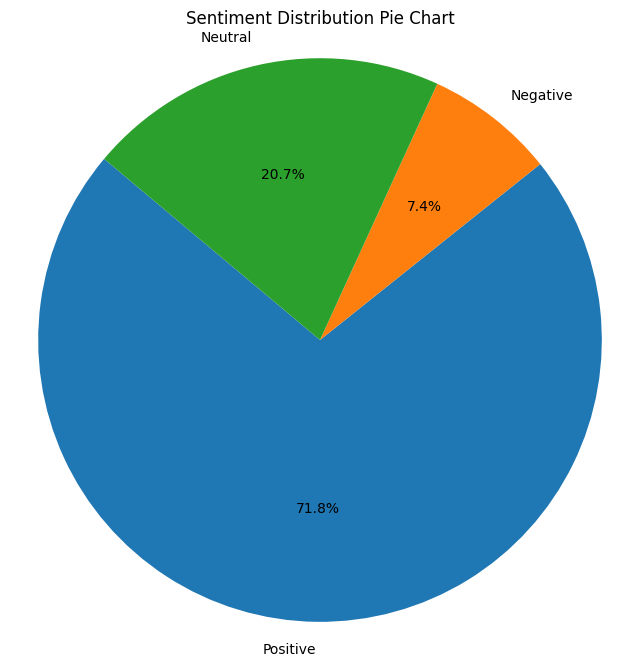

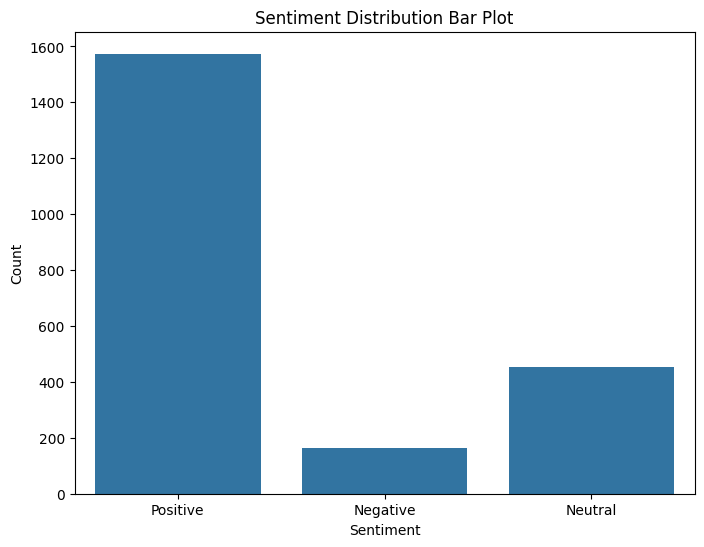

Sentiment Distribution Plots Generated.

Generating Monthly Sentiment Trend Plot...


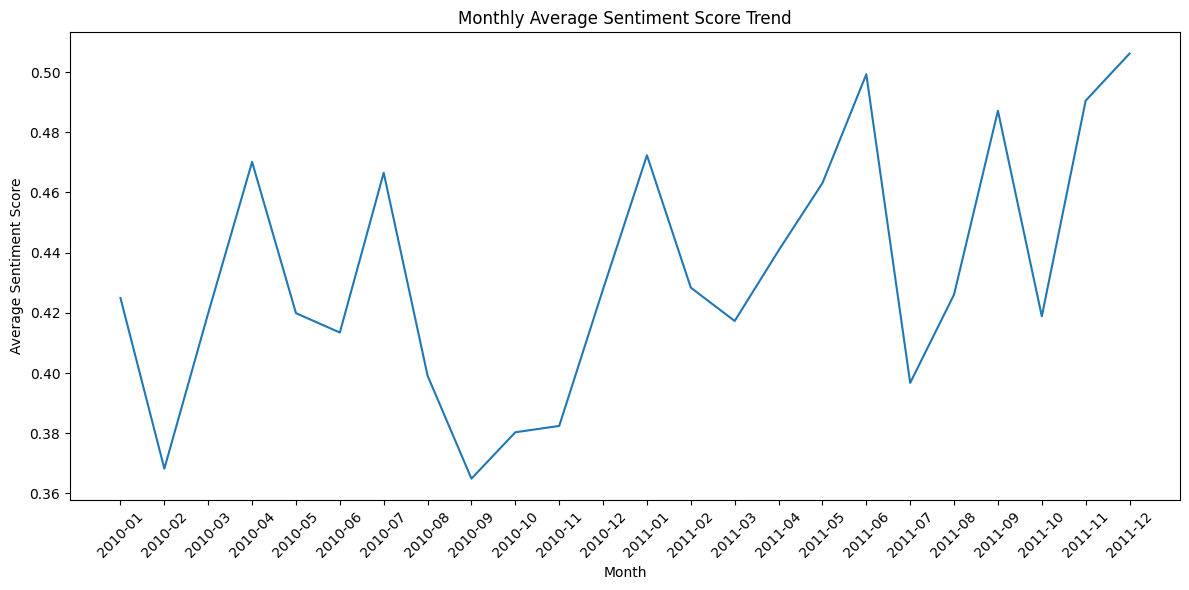

Monthly Sentiment Trend Plot Generated.

Generating Improved Word Clouds...


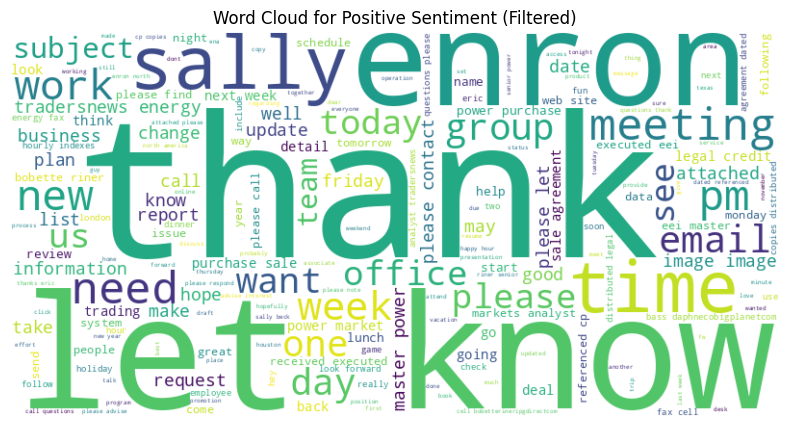

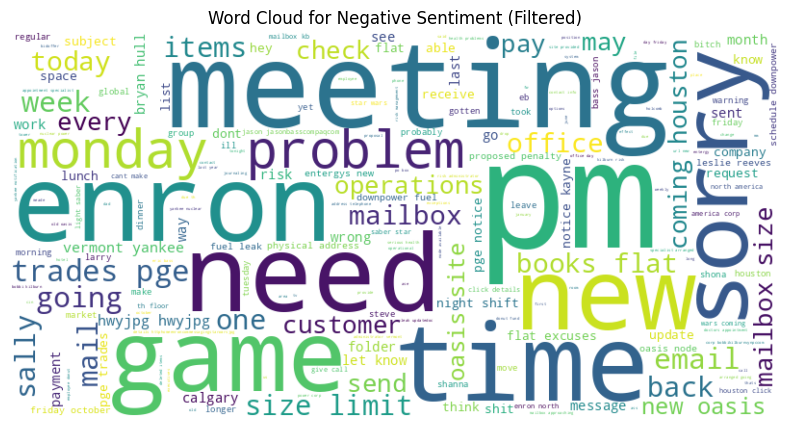

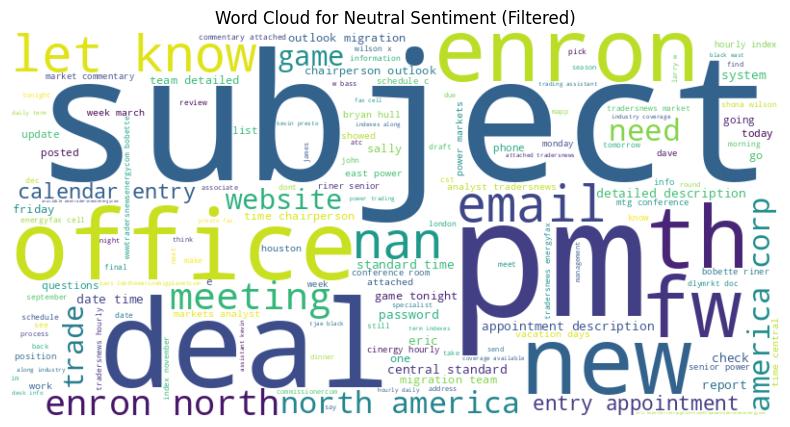

Improved Word Clouds Generated.

Generating Employee Monthly Sentiment Heatmap...


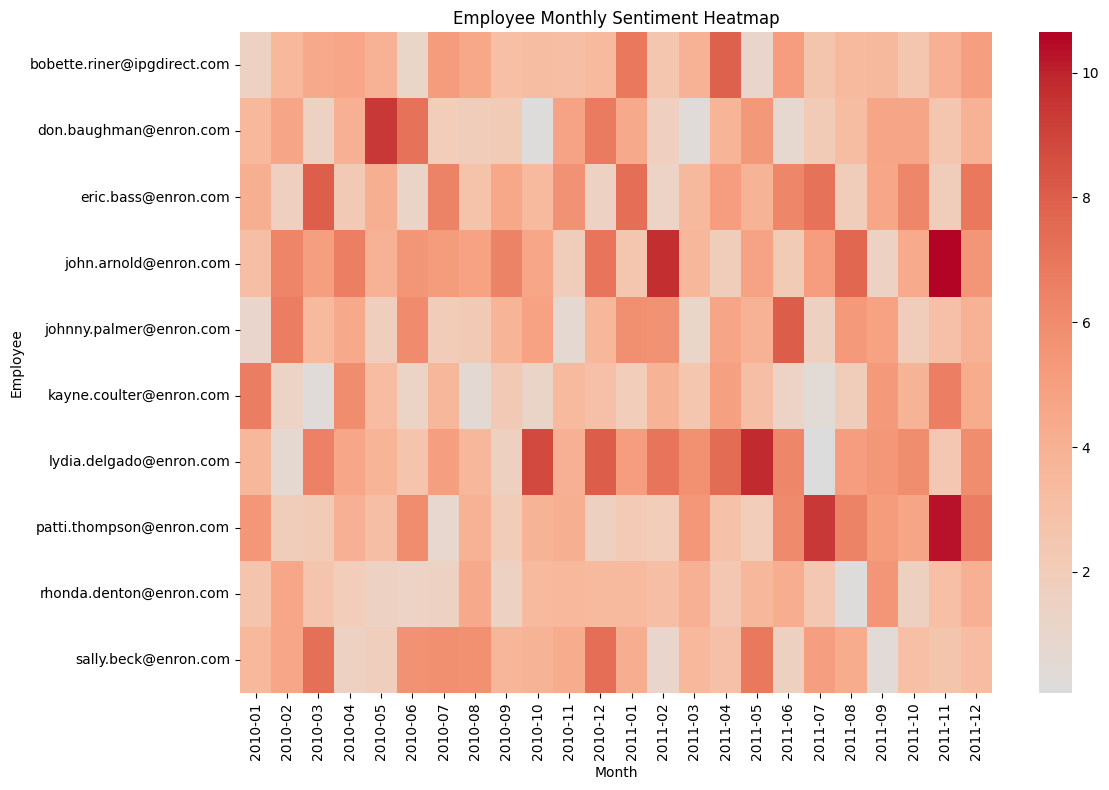

Employee Monthly Sentiment Heatmap Generated.

Generating Feature Correlation Heatmap...


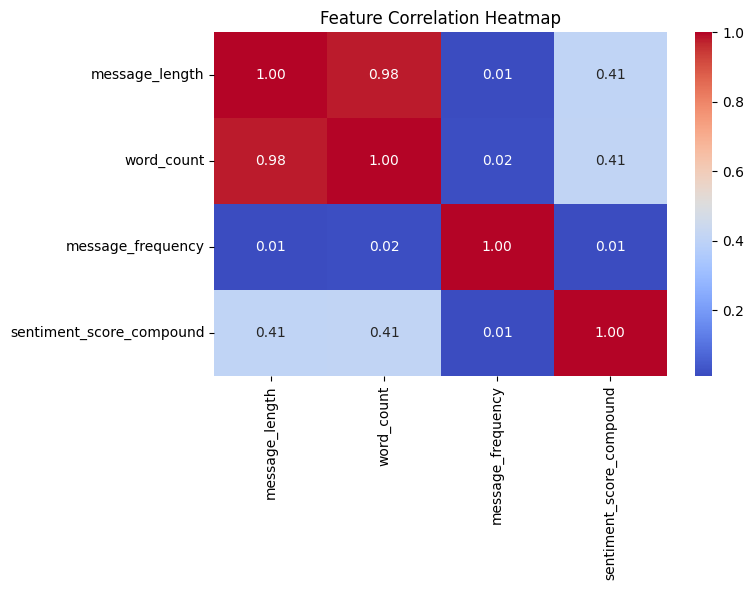

Feature Correlation Heatmap Generated.

EDA complete.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from wordcloud import WordCloud # Import WordCloud here as it's used in this cell
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re # Import regex for cleaning text

# Download stopwords if not already present
import nltk
nltk.download('stopwords', quiet=True)


# Load the labeled dataset
try:
    # Prefer loading from the transformer file if it exists, otherwise fall back to VADER file
    # Update to load the .xlsx file saved by the VADER cell
    if os.path.exists('data/labeled_dataset_transformer.csv'):
        df = pd.read_csv('data/labeled_dataset_transformer.csv')
        print('Labeled Dataset loaded from: data/labeled_dataset_transformer.csv')
        sentiment_col_source = 'transformer'
    elif os.path.exists('data/labeled_dataset.xlsx'): # Check for the .xlsx file first
        df = pd.read_excel('data/labeled_dataset.xlsx')
        print('Labeled Dataset loaded from: data/labeled_dataset.xlsx')
        sentiment_col_source = 'vader' # Assuming .xlsx comes from VADER for now
    elif os.path.exists('data/labeled_dataset.csv'): # Keep .csv as a fallback if it exists
        df = pd.read_csv('data/labeled_dataset.csv')
        print('Labeled Dataset loaded from: data/labeled_dataset.csv')
        sentiment_col_source = 'vader' # Assuming .csv also comes from VADER

    else:
        print("Error: Neither labeled_dataset_transformer.csv, labeled_dataset.xlsx nor labeled_dataset.csv found in the 'data/' directory. Please ensure the sentiment labeling step has been run successfully.")
        # Stop execution or handle appropriately if the file is essential
        raise FileNotFoundError("Labeled dataset not found")

    print('Labeled Dataset Shape:', df.shape)
    print('Columns:', ', '.join(df.columns))

except FileNotFoundError:
    print("Error loading labeled dataset. Please ensure the sentiment labeling step has been run successfully.")
    # Stop execution or handle appropriately if the file is essential
    raise FileNotFoundError("Labeled dataset not found")


# Basic dataset overview
print('Data Overview')
print(df.describe(include='all'))
print('Missing Values:')
print(df.isnull().sum())

# Create the visualizations directory if it doesn't exist
os.makedirs('visualizations', exist_ok=True)

# Determine which sentiment column to use
# Use the column based on which file was loaded
if sentiment_col_source == 'transformer':
    sentiment_col = 'sentiment_transformer'
    sentiment_score_col = 'sentiment_score_transformer'
elif sentiment_col_source == 'vader':
     sentiment_col = 'sentiment'
     sentiment_score_col = 'sentiment_score_compound'
else:
     print("Error: Could not determine sentiment column based on loaded file. Attempting to auto-detect.")
     sentiment_col = 'sentiment' # Default guess
     sentiment_score_col = 'sentiment_score_compound' # Default guess
     if sentiment_col not in df.columns and 'sentiment_transformer' in df.columns:
         sentiment_col = 'sentiment_transformer'
     if sentiment_score_col not in df.columns and 'sentiment_score_transformer' in df.columns:
          sentiment_score_col = 'sentiment_score_transformer'


if sentiment_col not in df.columns:
     print(f"Error: Sentiment column '{sentiment_col}' not found in DataFrame. Cannot generate sentiment plots.")
     sentiment_col = None # Ensure sentiment_col is None if column is missing


if sentiment_col:
    # --- Sentiment Distribution Visualizations ---
    print(f"\nGenerating Sentiment Distribution Plots using '{sentiment_col}'...")
    # Handle cases where sentiment_col might not have all expected categories
    valid_sentiments = ['Positive', 'Negative', 'Neutral']
    sentiment_counts = df[sentiment_col].value_counts().reindex(valid_sentiments, fill_value=0)


    # Pie chart for sentiment distribution
    if not sentiment_counts.empty and sentiment_counts.sum() > 0:
        plt.figure(figsize=(8, 8))
        plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140)
        plt.title('Sentiment Distribution Pie Chart')
        plt.axis('equal')
        plt.savefig('visualizations/sentiment_distribution_pie_chart.png')
        plt.show()
    else:
        print("No data to generate sentiment distribution pie chart.")


    # Bar plot for sentiment distribution
    if not sentiment_counts.empty and sentiment_counts.sum() > 0:
        plt.figure(figsize=(8, 6))
        sns.countplot(data=df, x=sentiment_col, order=sentiment_counts.index)
        plt.title('Sentiment Distribution Bar Plot')
        plt.xlabel('Sentiment')
        plt.ylabel('Count')
        plt.savefig('visualizations/sentiment_distribution_bar_plot.png')
        plt.show()
    else:
         print("No data to generate sentiment distribution bar plot.")
    print("Sentiment Distribution Plots Generated.")
else:
    print("\nSkipping Sentiment Distribution Plots due to missing sentiment column.")


# --- Monthly Sentiment Trend Analysis ---
print("\nGenerating Monthly Sentiment Trend Plot...")
# Ensure 'date' is datetime and sentiment score column exists
if 'date' not in df.columns or not pd.api.types.is_datetime64_any_dtype(df['date']):
     df['date'] = pd.to_datetime(df['date'], errors='coerce')
# If sentiment_score_col was not determined above, try to determine it now
if sentiment_score_col is None or sentiment_score_col not in df.columns:
     if 'sentiment_score_compound' in df.columns:
          sentiment_score_col = 'sentiment_score_compound'
     elif 'sentiment_score_transformer' in df.columns:
          sentiment_score_col = 'sentiment_score_transformer'
     else:
          print("Warning: No sentiment score column found. Calculating default 'sentiment_score'.")
          if sentiment_col and sentiment_col in df.columns:
              sentiment_map = {'Positive': 1, 'Negative': -1, 'Neutral': 0}
              df['sentiment_score_default'] = df[sentiment_col].map(sentiment_map)
              sentiment_score_col = 'sentiment_score_default'
          else:
              print("Cannot calculate default sentiment score as no suitable sentiment column exists.")
              sentiment_score_col = None

if sentiment_score_col and 'date' in df.columns and not df['date'].isnull().all():
    df['year_month'] = df['date'].dt.to_period('M')
    monthly_avg_sentiment = df.groupby('year_month')[sentiment_score_col].mean().reset_index()
    monthly_avg_sentiment['year_month'] = monthly_avg_sentiment['year_month'].astype(str)

    plt.figure(figsize=(12, 6))
    sns.lineplot(data=monthly_avg_sentiment, x='year_month', y=sentiment_score_col)
    plt.title('Monthly Average Sentiment Score Trend')
    plt.xlabel('Month')
    plt.ylabel('Average Sentiment Score')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('visualizations/monthly_sentiment_trend.png')
    plt.show()
    print("Monthly Sentiment Trend Plot Generated.")
else:
    print("Skipping Monthly Sentiment Trend Plot due to missing date column or sentiment score.")


# --- Improved Word Clouds ---
print("\nGenerating Improved Word Clouds...")
# Initialize VADER for lexicon access
sia_wc = SentimentIntensityAnalyzer()
stop_words = set(stopwords.words('english'))

# Ensure 'combined_text' is string type and handle potential NaNs
df['combined_text'] = df['combined_text'].astype(str).fillna('')

def clean_text_for_wordcloud(text, sentiment_type=None):
    # Remove non-alphabetic characters and convert to lower case
    text = re.sub(r'[^a-zA-Z\s]', '', text.lower())
    words = text.split()
    filtered_words = []
    for word in words:
        if word not in stop_words:
            # Optional: Filter based on VADER lexicon score for more sentiment-specific words
            # This is a simplified approach; more complex filtering could be used
            if sentiment_type == 'Positive':
                if sia_wc.polarity_scores(word)['pos'] > 0.3: # Threshold can be adjusted
                     filtered_words.append(word)
                elif sia_wc.polarity_scores(word)['neg'] == 0 and sia_wc.polarity_scores(word)['neu'] == 1: # Include neutral words if they appear often
                    filtered_words.append(word)
            elif sentiment_type == 'Negative':
                 if sia_wc.polarity_scores(word)['neg'] > 0.3: # Threshold can be adjusted
                     filtered_words.append(word)
                 elif sia_wc.polarity_scores(word)['pos'] == 0 and sia_wc.polarity_scores(word)['neu'] == 1: # Include neutral words if they appear often
                    filtered_words.append(word)
            else: # For neutral or general word cloud
                 filtered_words.append(word)

    return " ".join(filtered_words)

if sentiment_col and sentiment_col in df.columns:
    positive_text_cleaned = clean_text_for_wordcloud(" ".join(df[df[sentiment_col] == 'Positive']['combined_text'].tolist()), 'Positive')
    negative_text_cleaned = clean_text_for_wordcloud(" ".join(df[df[sentiment_col] == 'Negative']['combined_text'].tolist()), 'Negative')
    neutral_text_cleaned = clean_text_for_wordcloud(" ".join(df[df[sentiment_col] == 'Neutral']['combined_text'].tolist()), 'Neutral')


    def generate_wordcloud_viz(text, title, filename):
        if not text.strip(): # Check if text is empty or only whitespace
            print(f"No significant text available to generate word cloud for: {title}")
            return
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(title)
        plt.savefig(f'visualizations/{filename}.png')
        plt.show()

    generate_wordcloud_viz(positive_text_cleaned, 'Word Cloud for Positive Sentiment (Filtered)', 'wordcloud_positive_filtered')
    generate_wordcloud_viz(negative_text_cleaned, 'Word Cloud for Negative Sentiment (Filtered)', 'wordcloud_negative_filtered')
    generate_wordcloud_viz(neutral_text_cleaned, 'Word Cloud for Neutral Sentiment (Filtered)', 'wordcloud_neutral_filtered')
    print("Improved Word Clouds Generated.")
else:
    print("\nSkipping Improved Word Cloud generation due to missing sentiment column.")


# --- Employee-level Sentiment Heatmap ---
print("\nGenerating Employee Monthly Sentiment Heatmap...")
# Ensure 'monthly_scores' DataFrame is available or recreate it
# This part relies on 'sentiment_score' which might be the default one calculated above
if 'monthly_scores' not in locals() and 'monthly_scores' not in globals():
    if 'date' not in df.columns or not pd.api.types.is_datetime64_any_dtype(df['date']):
        df['date'] = pd.to_datetime(df['date'], errors='coerce')
    # Use the determined sentiment_score_col or calculate a default if needed
    if sentiment_score_col is None or sentiment_score_col not in df.columns:
         print("Cannot generate Employee Monthly Sentiment Heatmap due to missing sentiment score.")
    else:
        df['year_month'] = df['date'].dt.to_period('M')
        # Ensure 'year_month' column exists and is not all NaT before grouping
        if 'year_month' in df.columns and not df['year_month'].isnull().all():
            monthly_scores = df.groupby(['from', 'year_month']).agg({sentiment_score_col: 'sum'}).reset_index()
            # Rename the sentiment score column for consistency in plotting/pivot
            monthly_scores = monthly_scores.rename(columns={sentiment_score_col: 'sentiment_score'})
        else:
            print("Skipping monthly scores calculation for heatmap due to missing or invalid date/year_month data.")
            monthly_scores = pd.DataFrame() # Create empty df to avoid errors


if 'monthly_scores' in locals() or 'monthly_scores' in globals() and not monthly_scores.empty:
    # Ensure year_month column exists in monthly_scores
    if 'year_month' in monthly_scores.columns:
        monthly_sentiment_pivot = monthly_scores.pivot(index='from', columns='year_month', values='sentiment_score').fillna(0)

        plt.figure(figsize=(12, 8))
        sns.heatmap(monthly_sentiment_pivot, cmap='coolwarm', center=0)
        plt.title('Employee Monthly Sentiment Heatmap')
        plt.xlabel('Month')
        plt.ylabel('Employee')
        plt.tight_layout()
        plt.savefig('visualizations/employee_sentiment_heatmap.png')
        plt.show()
        print("Employee Monthly Sentiment Heatmap Generated.")
    else:
         print("Skipping Employee Monthly Sentiment Heatmap due to missing 'year_month' in monthly_scores.")

else:
    print("Skipping Employee Monthly Sentiment Heatmap due to missing data.")


# --- Feature Correlation Heatmap ---
print("\nGenerating Feature Correlation Heatmap...")
# Ensure necessary numerical features are available or recreate them
if 'message_length' not in df.columns or 'word_count' not in df.columns or 'message_frequency' not in df.columns:
    df['body'] = df['body'].astype(str).fillna('')
    df['message_length'] = df['body'].apply(len)
    df['word_count'] = df['body'].apply(lambda x: len(x.split()))
    message_frequency = df['from'].value_counts().reset_index()
    message_frequency.columns = ['from', 'message_frequency']
    # Drop existing message frequency columns if they exist before merging (important for re-running)
    df = df.drop(columns=[col for col in df.columns if 'message_frequency' in col], errors='ignore')
    df = df.merge(message_frequency, on='from', how='left')

# Select numerical features for correlation analysis
numerical_features = ['message_length', 'word_count', 'message_frequency']
# Add the sentiment score column if it exists
if sentiment_score_col and sentiment_score_col in df.columns:
     numerical_features.append(sentiment_score_col)
elif 'sentiment_score_default' in df.columns:
     numerical_features.append('sentiment_score_default')


# Ensure selected columns exist before calculating correlation
numerical_features = [col for col in numerical_features if col in df.columns]

if len(numerical_features) > 1:
    correlation_matrix = df[numerical_features].corr()

    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Feature Correlation Heatmap')
    plt.tight_layout()
    plt.savefig('visualizations/feature_correlation_heatmap.png')
    plt.show()
    print("Feature Correlation Heatmap Generated.")
else:
    print("Insufficient numerical features to generate correlation heatmap.")

print("\nEDA complete.")

## Task 3: Employee Score Calculation
Calculate a monthly sentiment score for each employee.

In [7]:
# Map sentiment to scores
sentiment_map = {'Positive': 1, 'Negative': -1, 'Neutral': 0}
df['sentiment_score'] = df['sentiment'].map(sentiment_map)

# Parse dates
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['year_month'] = df['date'].dt.to_period('M')

# Calculate monthly sentiment score
monthly_scores = df.groupby(['from', 'year_month']).agg({'sentiment_score': 'sum'}).reset_index()
print(monthly_scores.head())

# Save monthly scores to CSV
os.makedirs('data', exist_ok=True) # Ensure directory exists
monthly_scores.to_csv('data/monthly_scores.csv', index=False)
print("Monthly scores saved to data/monthly_scores.csv")

                          from year_month  sentiment_score
0  bobette.riner@ipgdirect.com    2010-01                2
1  bobette.riner@ipgdirect.com    2010-02                5
2  bobette.riner@ipgdirect.com    2010-03                6
3  bobette.riner@ipgdirect.com    2010-04                6
4  bobette.riner@ipgdirect.com    2010-05                5
Monthly scores saved to data/monthly_scores.csv


## Task 4: Employee Ranking
Generate ranked lists of employees based on their monthly sentiment scores.

Top 3 Positive Employees per Month:


,from,year_month,sentiment_score
120,kayne.coulter@enron.com,2010-01,12
168,patti.thompson@enron.com,2010-01,8
24,don.baughman@enron.com,2010-01,6
73,john.arnold@enron.com,2010-02,12
97,johnny.palmer@enron.com,2010-02,8
...,...,...,...
190,patti.thompson@enron.com,2011-11,13
142,kayne.coulter@enron.com,2011-11,10
191,patti.thompson@enron.com,2011-12,11
71,eric.bass@enron.com,2011-12,10



Top 3 Negative Employees per Month:


,from,year_month,sentiment_score
0,bobette.riner@ipgdirect.com,2010-01,2
96,johnny.palmer@enron.com,2010-01,2
192,rhonda.denton@enron.com,2010-01,3
49,eric.bass@enron.com,2010-02,2
145,lydia.delgado@enron.com,2010-02,2
...,...,...,...
238,sally.beck@enron.com,2011-11,3
214,rhonda.denton@enron.com,2011-11,4
119,johnny.palmer@enron.com,2011-12,5
47,don.baughman@enron.com,2011-12,6



Employee rankings saved to data/top_positive_employee_rankings.csv and data/top_negative_employee_rankings.csv


/tmp/ipython-input-8-257331303.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=monthly_positive_rankings, x='from', y='sentiment_score', palette='viridis')


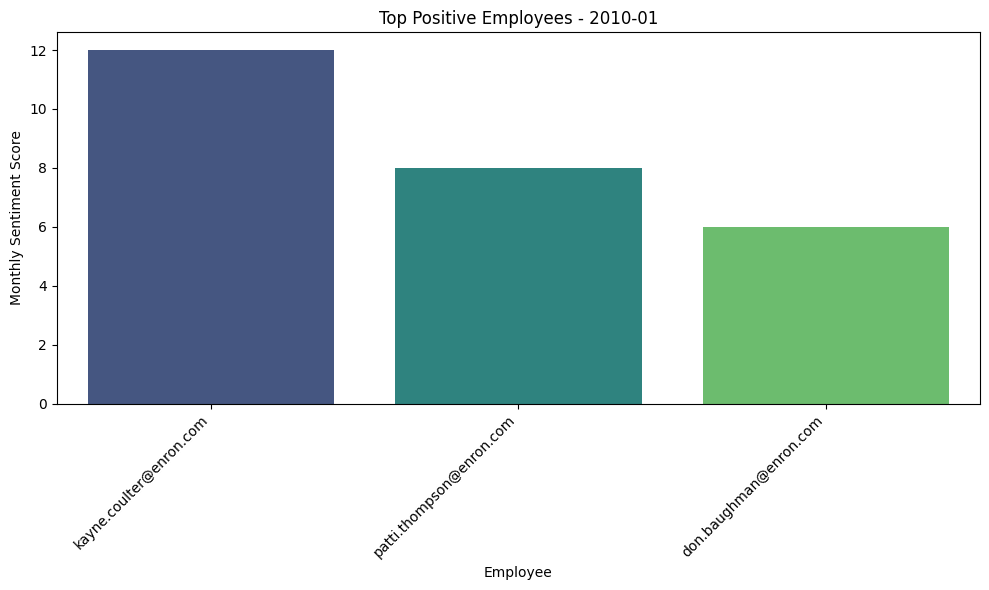

/tmp/ipython-input-8-257331303.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=monthly_negative_rankings, x='from', y='sentiment_score', palette='magma')


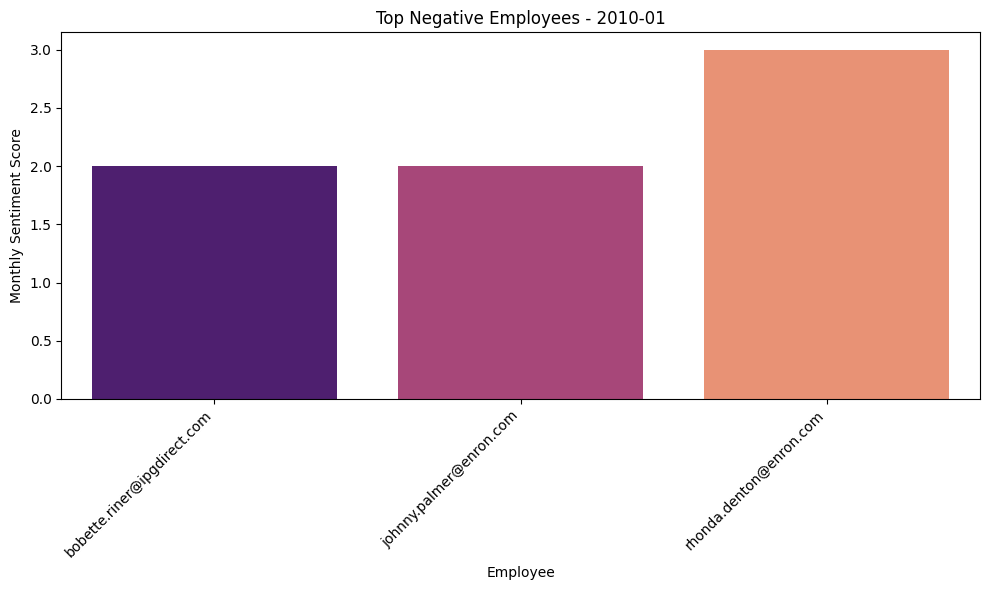

/tmp/ipython-input-8-257331303.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=monthly_positive_rankings, x='from', y='sentiment_score', palette='viridis')


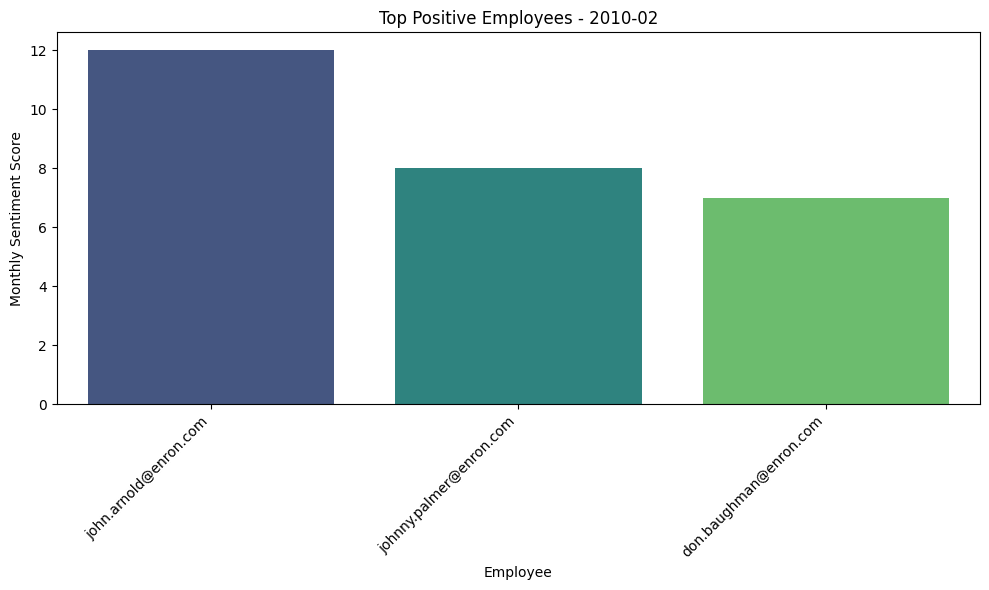

/tmp/ipython-input-8-257331303.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=monthly_negative_rankings, x='from', y='sentiment_score', palette='magma')


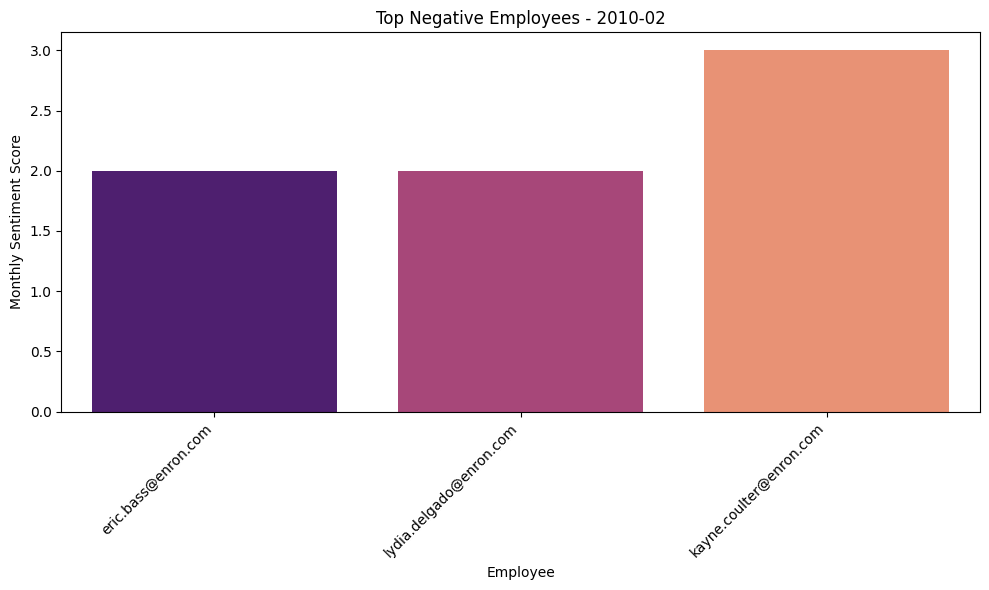

/tmp/ipython-input-8-257331303.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=monthly_positive_rankings, x='from', y='sentiment_score', palette='viridis')


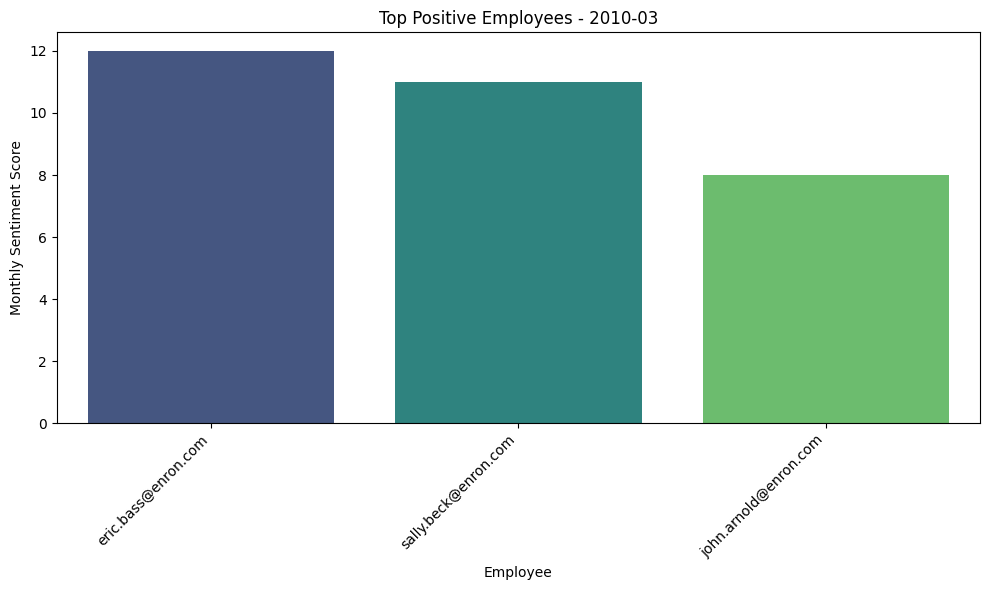

/tmp/ipython-input-8-257331303.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=monthly_negative_rankings, x='from', y='sentiment_score', palette='magma')


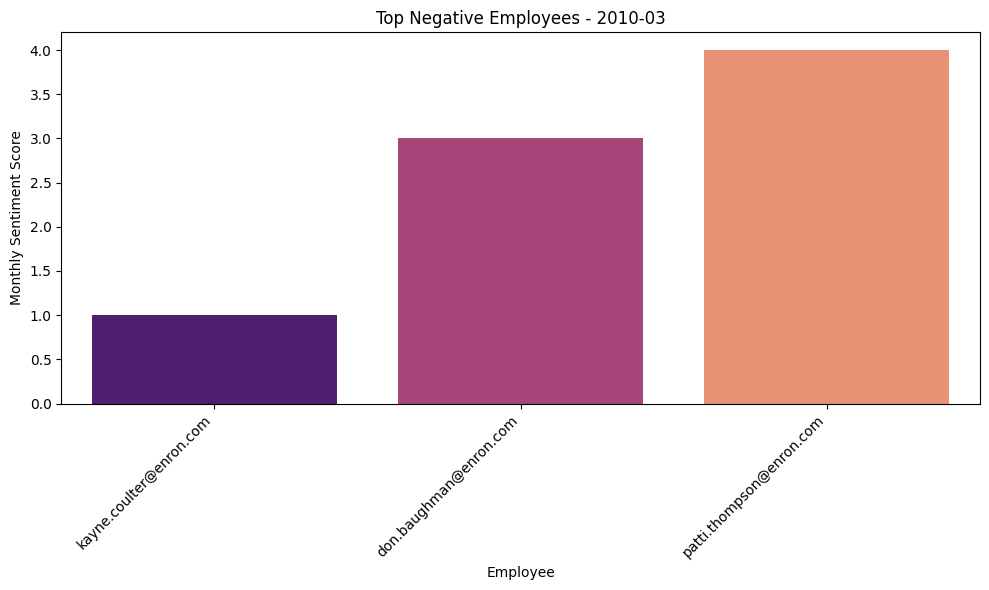

/tmp/ipython-input-8-257331303.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=monthly_positive_rankings, x='from', y='sentiment_score', palette='viridis')


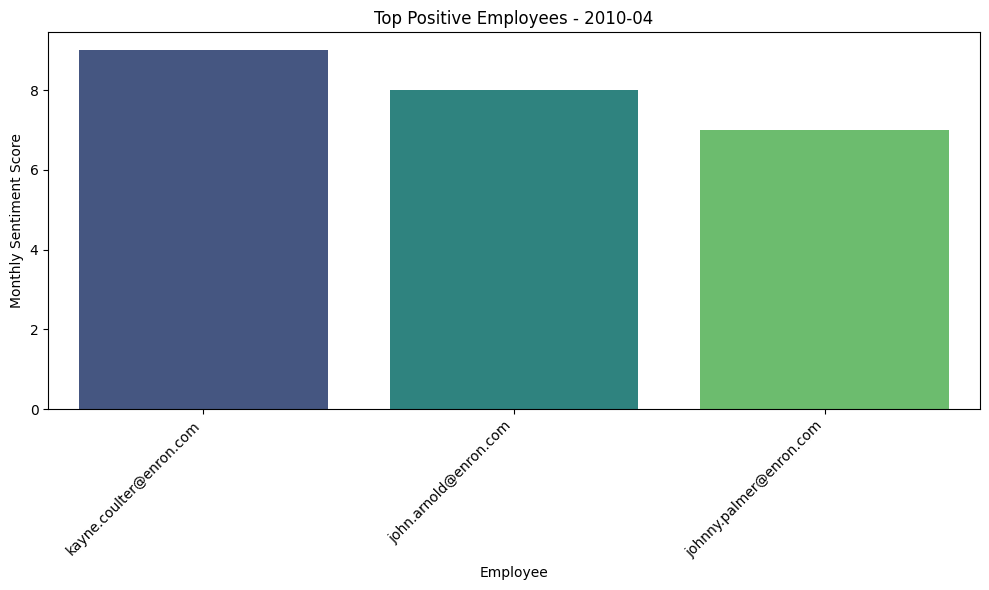

/tmp/ipython-input-8-257331303.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=monthly_negative_rankings, x='from', y='sentiment_score', palette='magma')


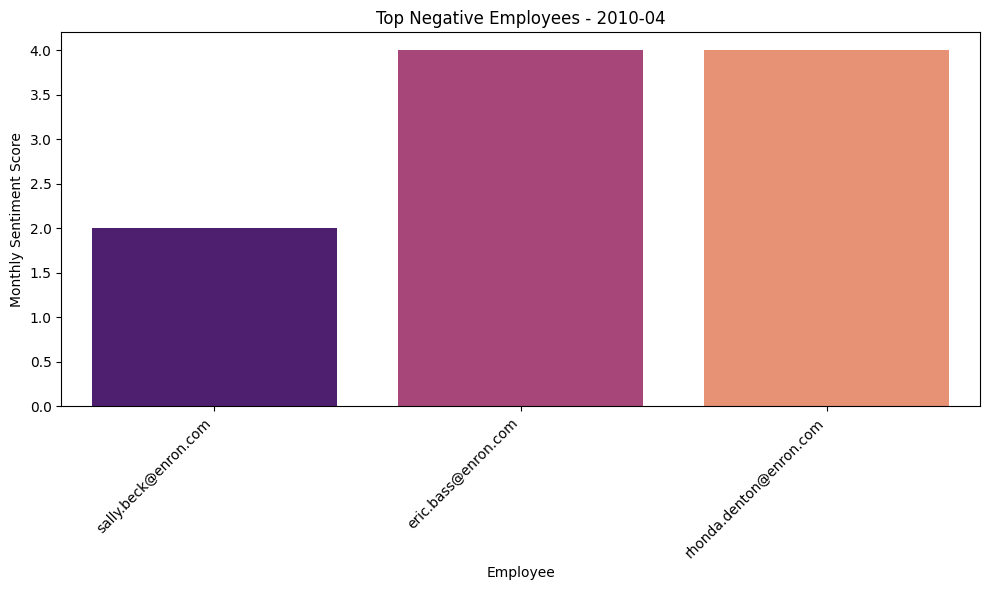

/tmp/ipython-input-8-257331303.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=monthly_positive_rankings, x='from', y='sentiment_score', palette='viridis')


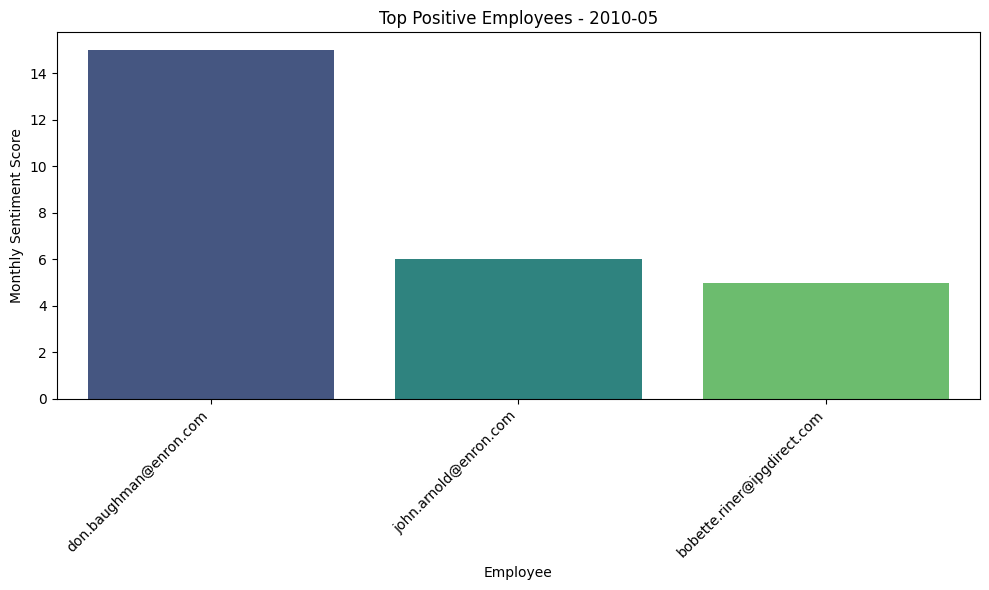

/tmp/ipython-input-8-257331303.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=monthly_negative_rankings, x='from', y='sentiment_score', palette='magma')


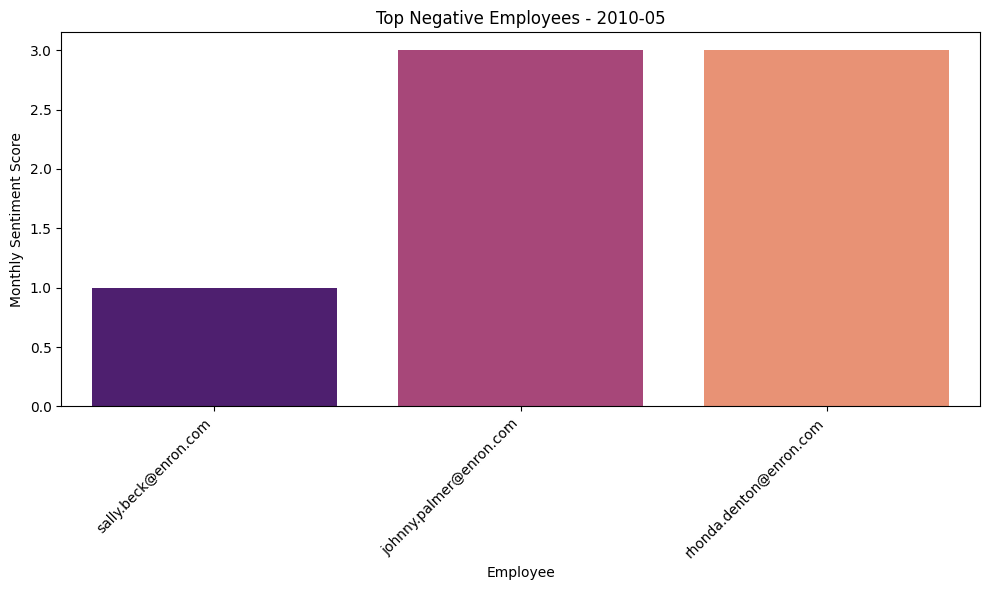

/tmp/ipython-input-8-257331303.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=monthly_positive_rankings, x='from', y='sentiment_score', palette='viridis')


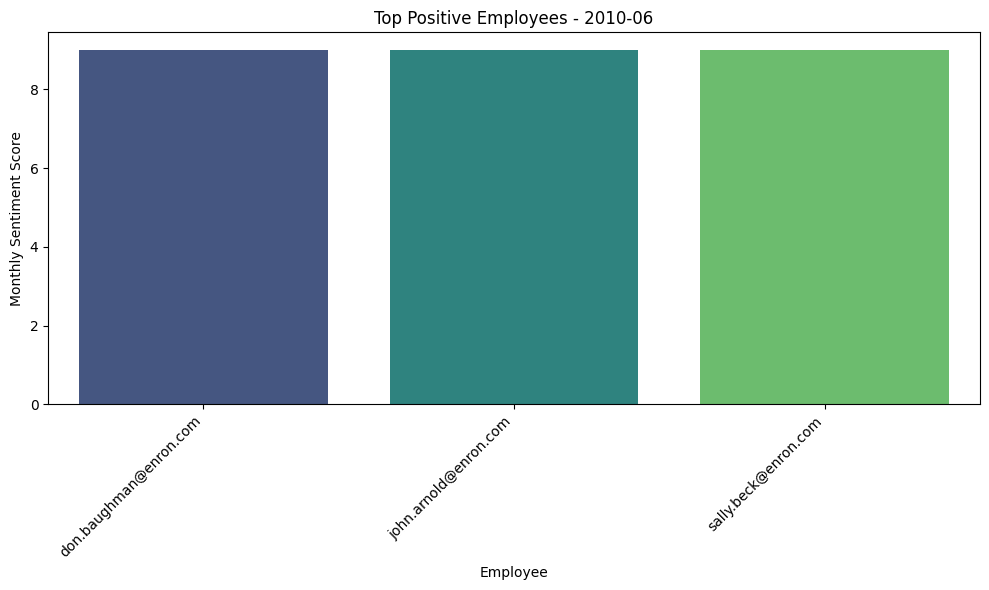

/tmp/ipython-input-8-257331303.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=monthly_negative_rankings, x='from', y='sentiment_score', palette='magma')


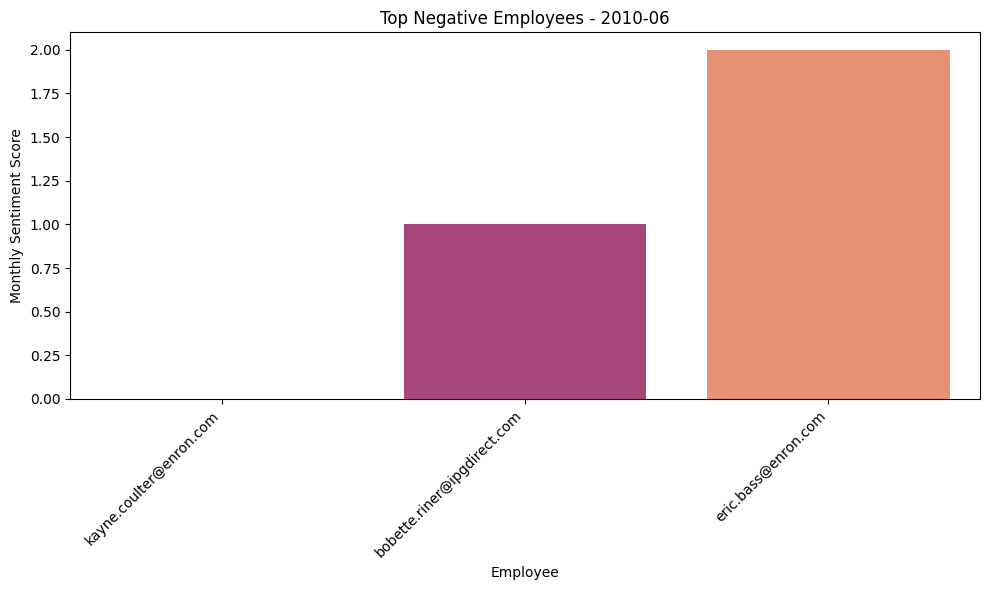

/tmp/ipython-input-8-257331303.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=monthly_positive_rankings, x='from', y='sentiment_score', palette='viridis')


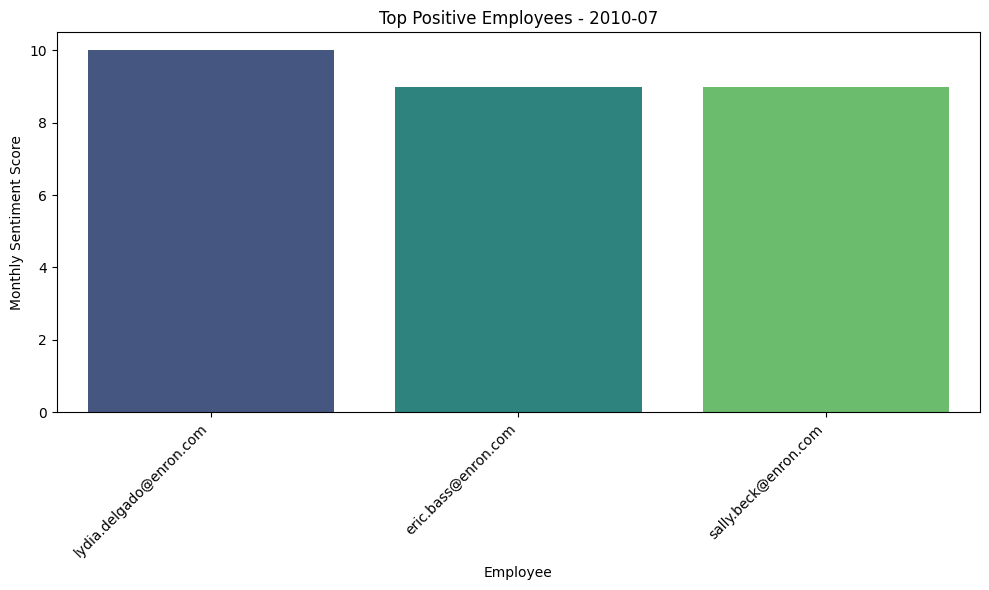

/tmp/ipython-input-8-257331303.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=monthly_negative_rankings, x='from', y='sentiment_score', palette='magma')


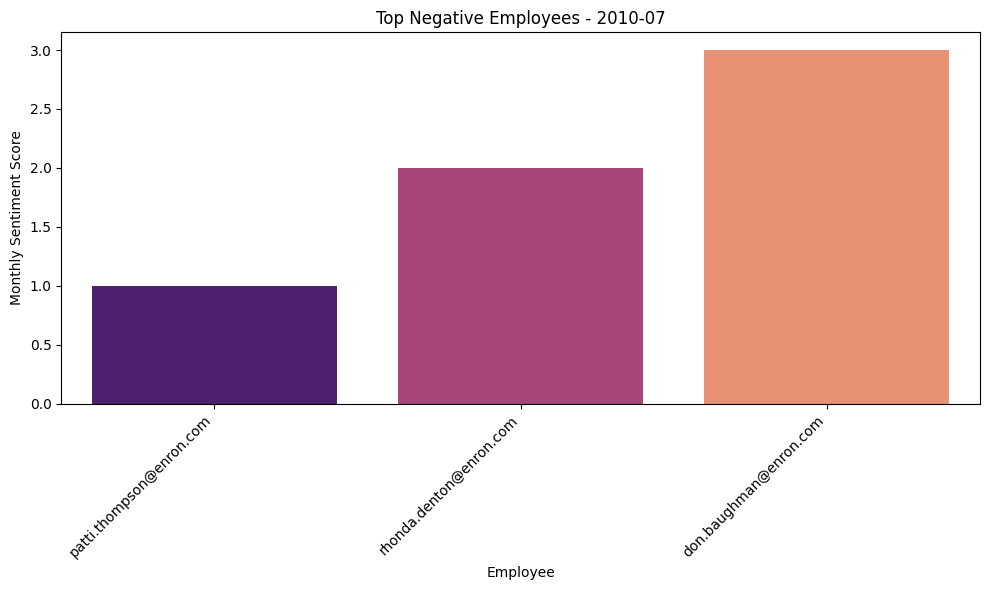

/tmp/ipython-input-8-257331303.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=monthly_positive_rankings, x='from', y='sentiment_score', palette='viridis')


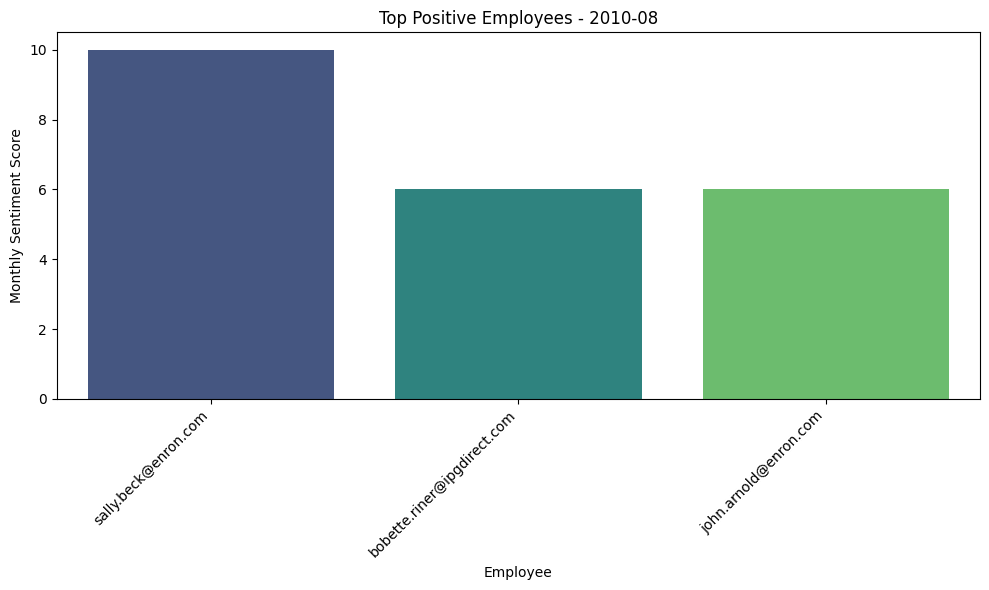

/tmp/ipython-input-8-257331303.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=monthly_negative_rankings, x='from', y='sentiment_score', palette='magma')


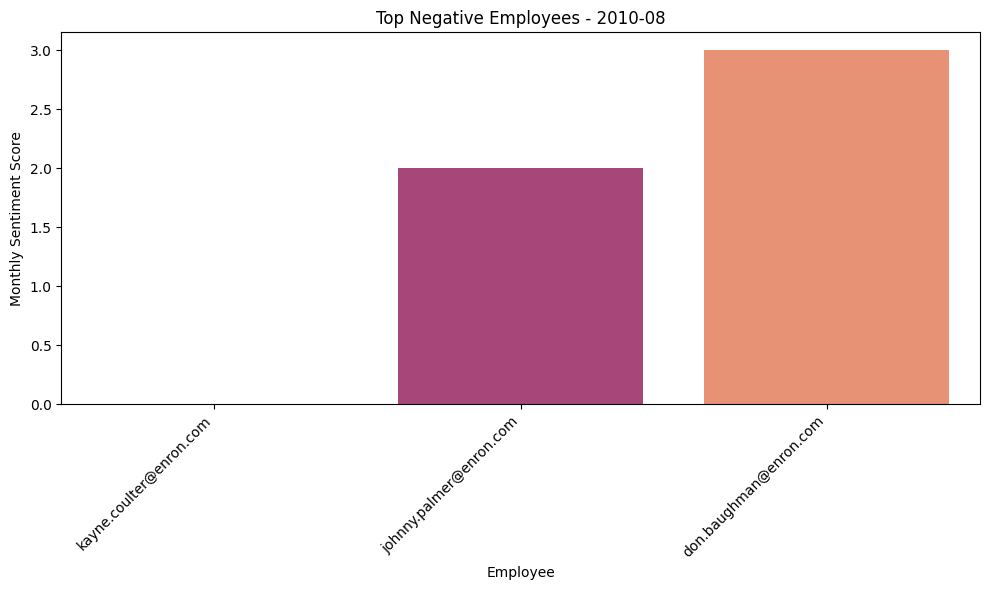

/tmp/ipython-input-8-257331303.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=monthly_positive_rankings, x='from', y='sentiment_score', palette='viridis')


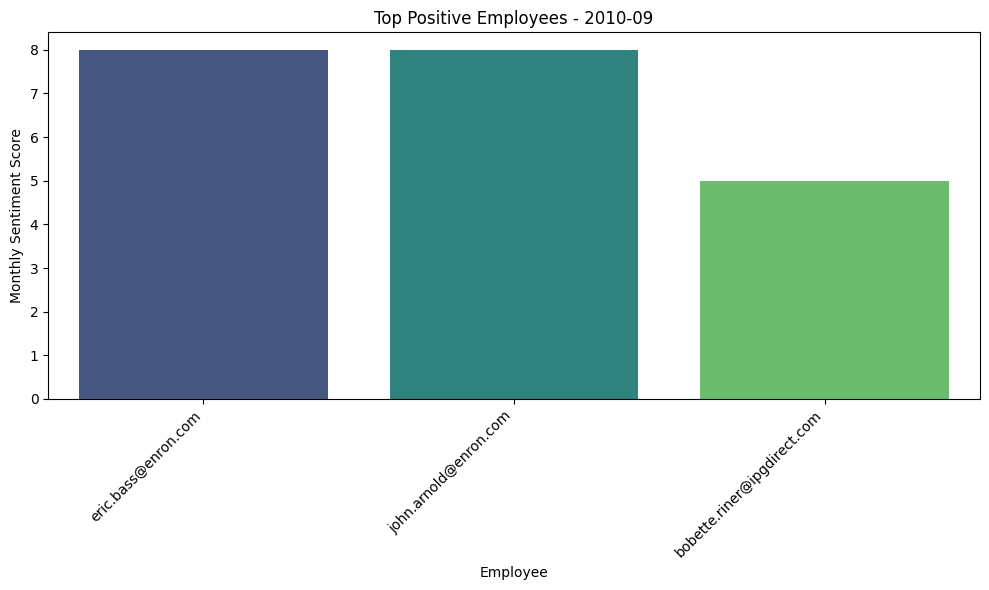

/tmp/ipython-input-8-257331303.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=monthly_negative_rankings, x='from', y='sentiment_score', palette='magma')


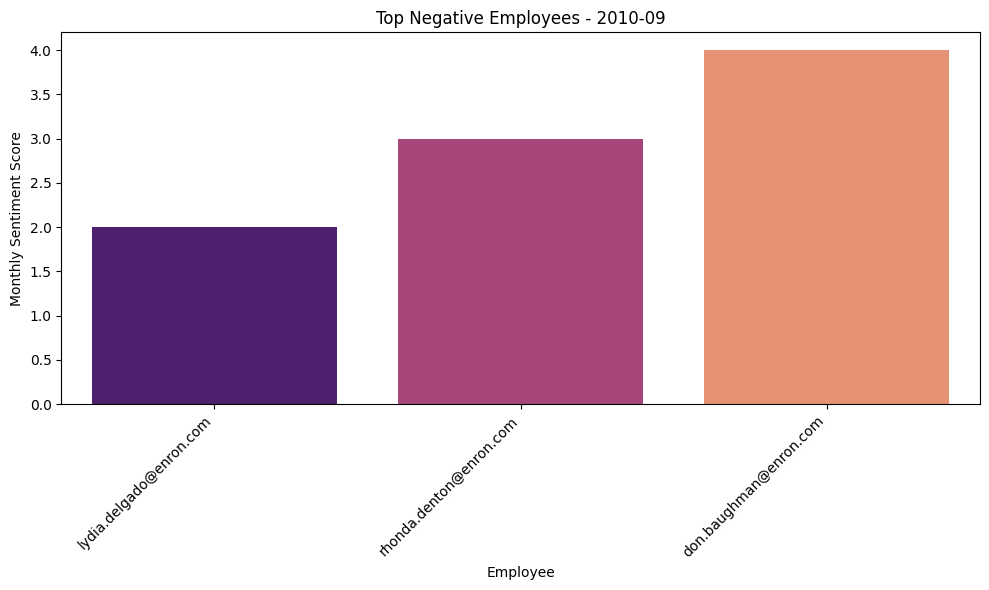

/tmp/ipython-input-8-257331303.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=monthly_positive_rankings, x='from', y='sentiment_score', palette='viridis')


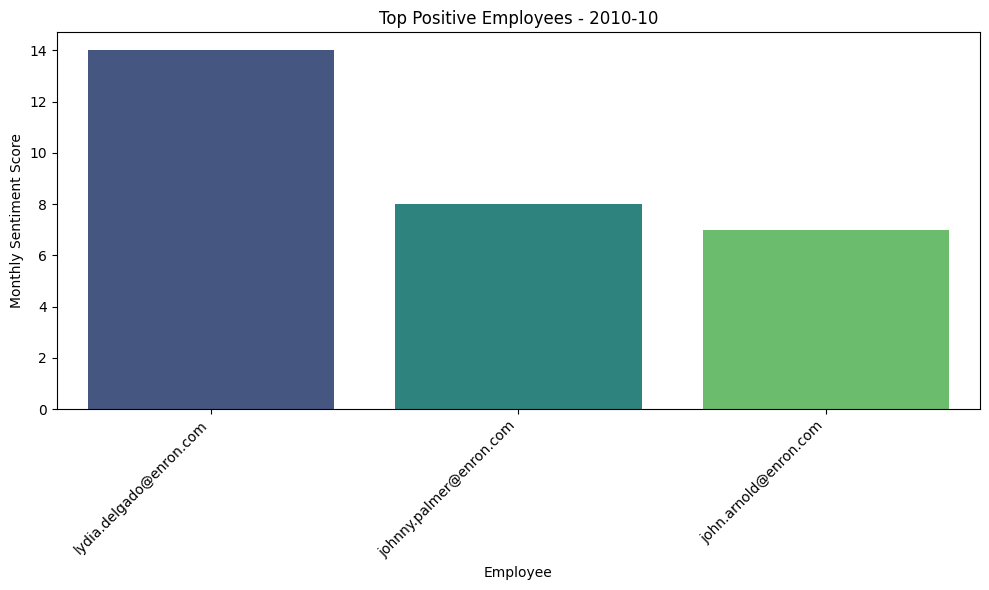

/tmp/ipython-input-8-257331303.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=monthly_negative_rankings, x='from', y='sentiment_score', palette='magma')


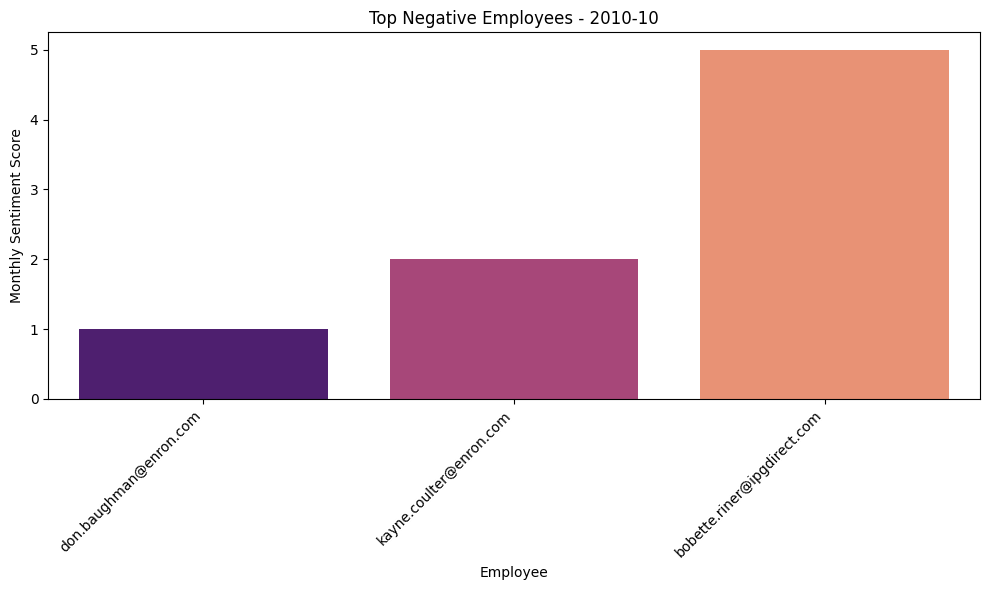

/tmp/ipython-input-8-257331303.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=monthly_positive_rankings, x='from', y='sentiment_score', palette='viridis')


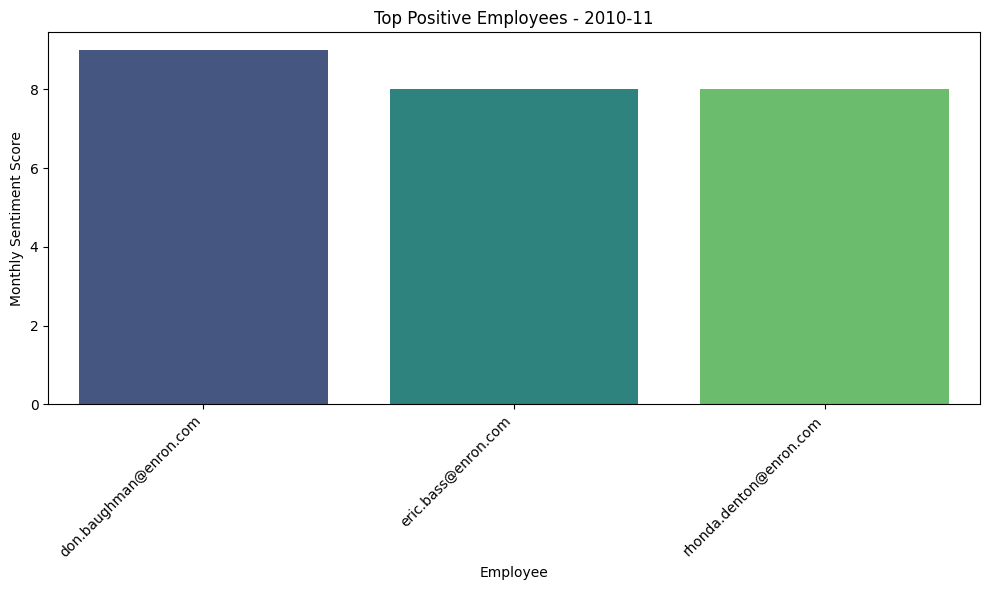

/tmp/ipython-input-8-257331303.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=monthly_negative_rankings, x='from', y='sentiment_score', palette='magma')


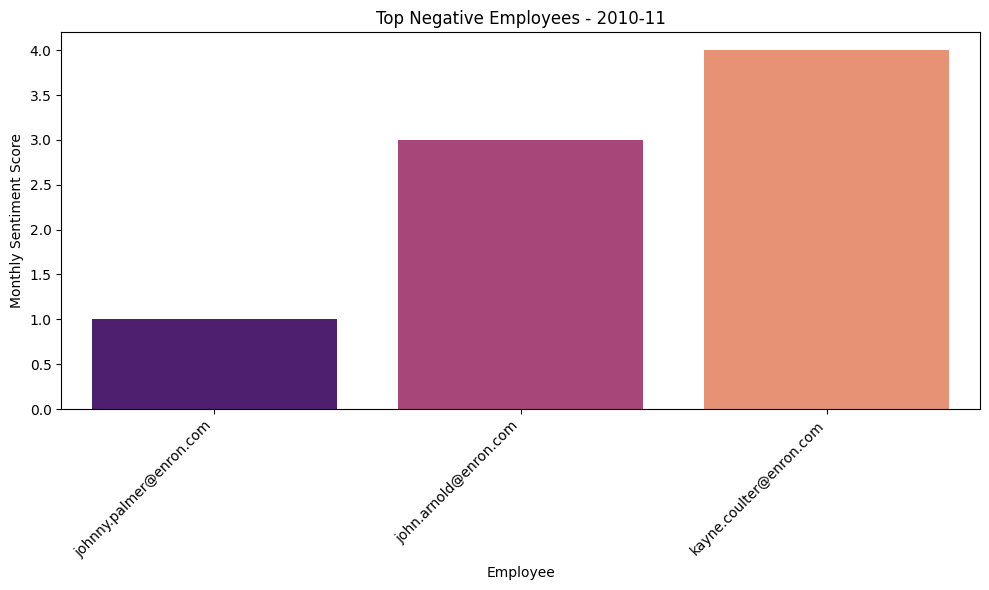

/tmp/ipython-input-8-257331303.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=monthly_positive_rankings, x='from', y='sentiment_score', palette='viridis')


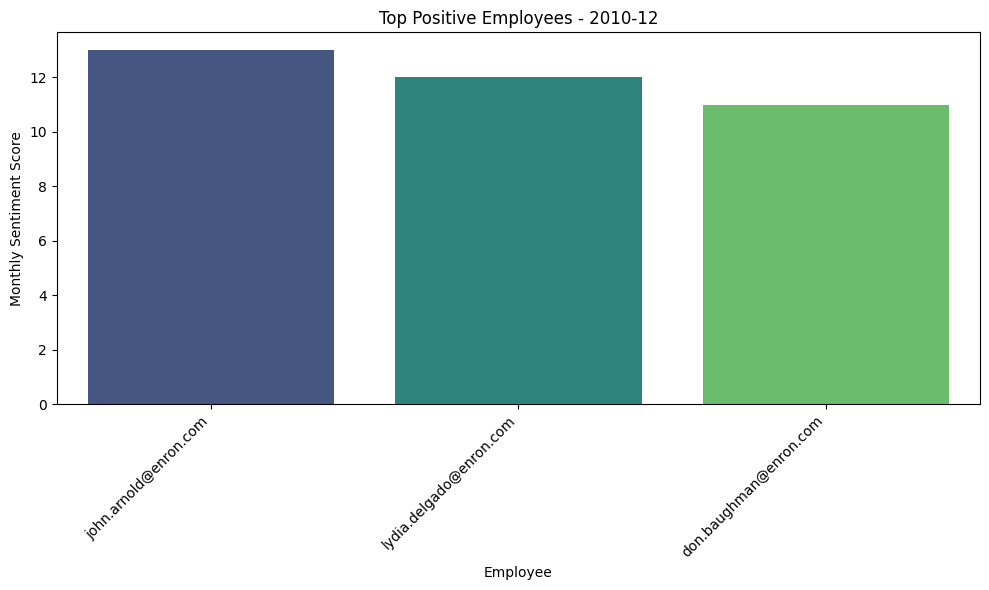

/tmp/ipython-input-8-257331303.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=monthly_negative_rankings, x='from', y='sentiment_score', palette='magma')


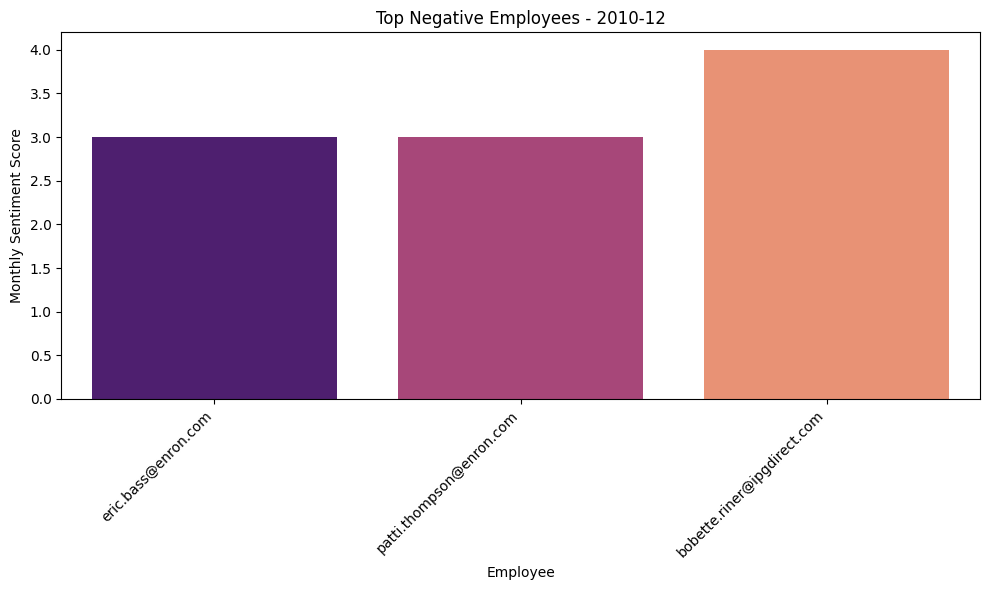

/tmp/ipython-input-8-257331303.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=monthly_positive_rankings, x='from', y='sentiment_score', palette='viridis')


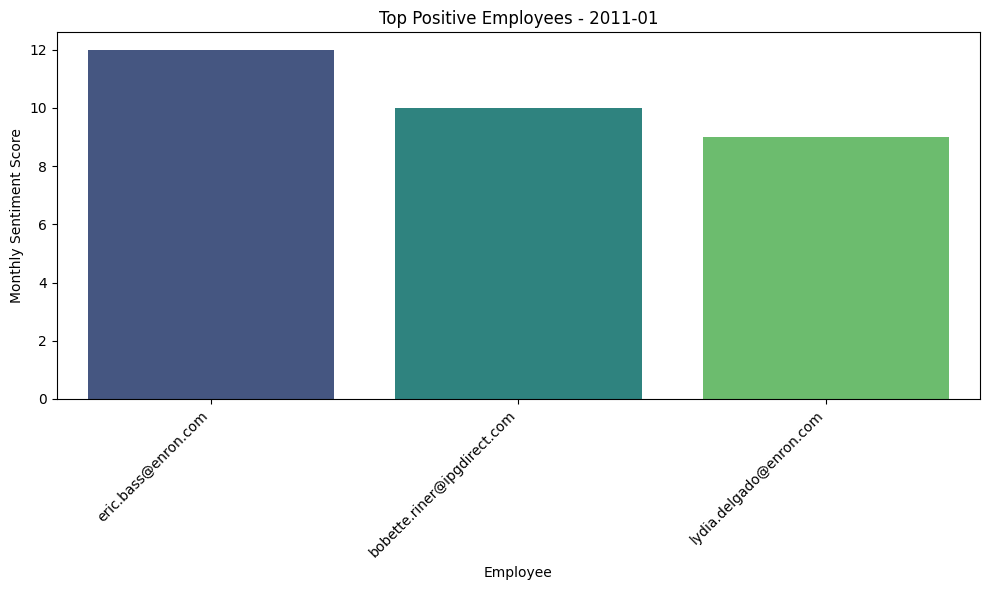

/tmp/ipython-input-8-257331303.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=monthly_negative_rankings, x='from', y='sentiment_score', palette='magma')


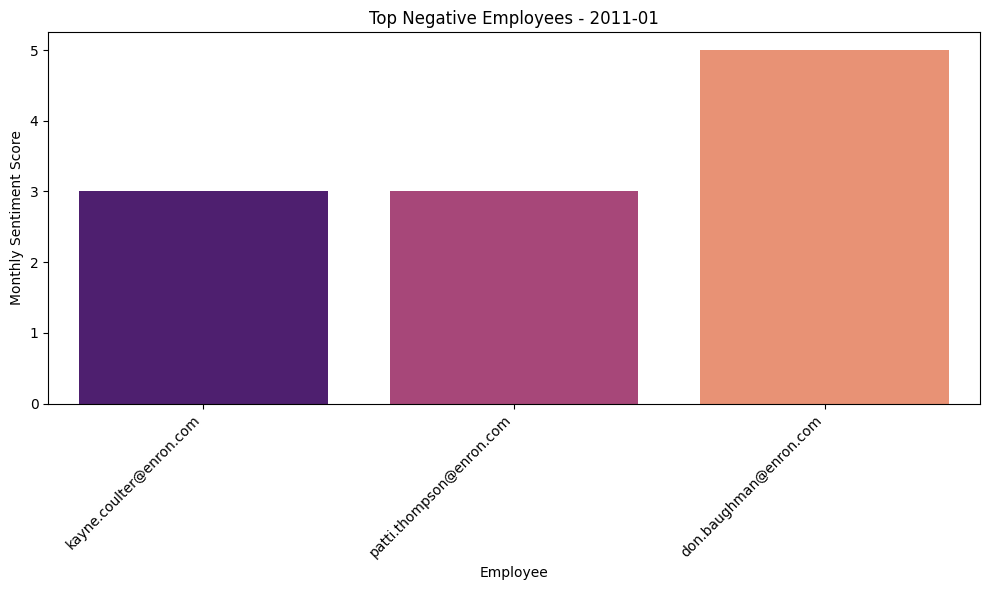

/tmp/ipython-input-8-257331303.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=monthly_positive_rankings, x='from', y='sentiment_score', palette='viridis')


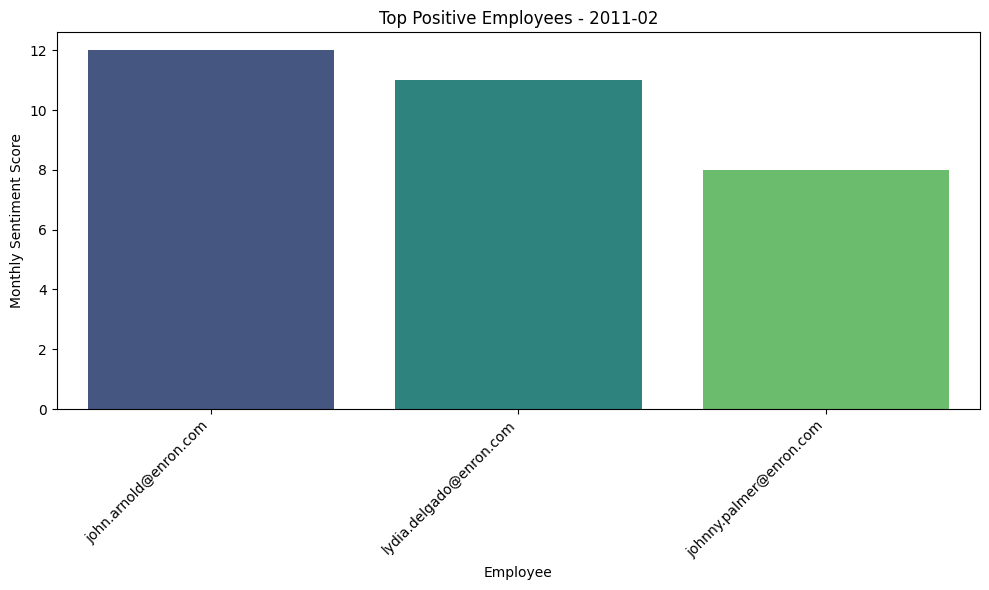

/tmp/ipython-input-8-257331303.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=monthly_negative_rankings, x='from', y='sentiment_score', palette='magma')


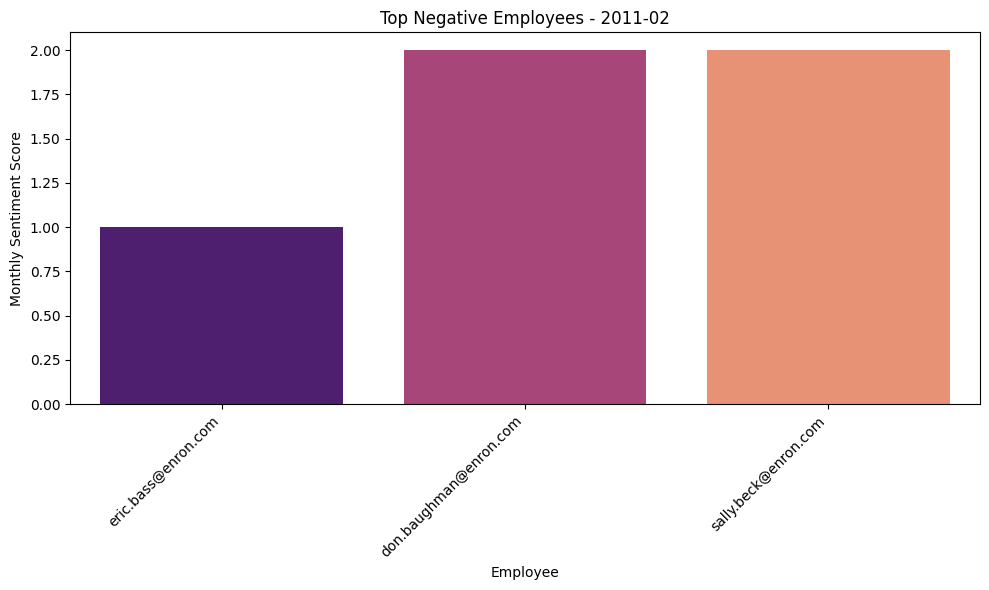

/tmp/ipython-input-8-257331303.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=monthly_positive_rankings, x='from', y='sentiment_score', palette='viridis')


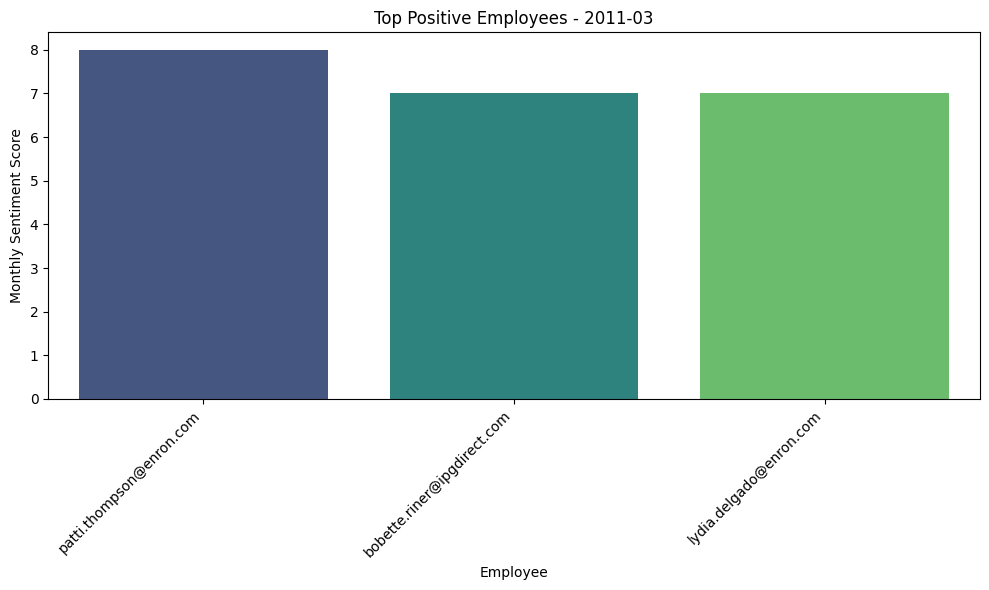

/tmp/ipython-input-8-257331303.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=monthly_negative_rankings, x='from', y='sentiment_score', palette='magma')


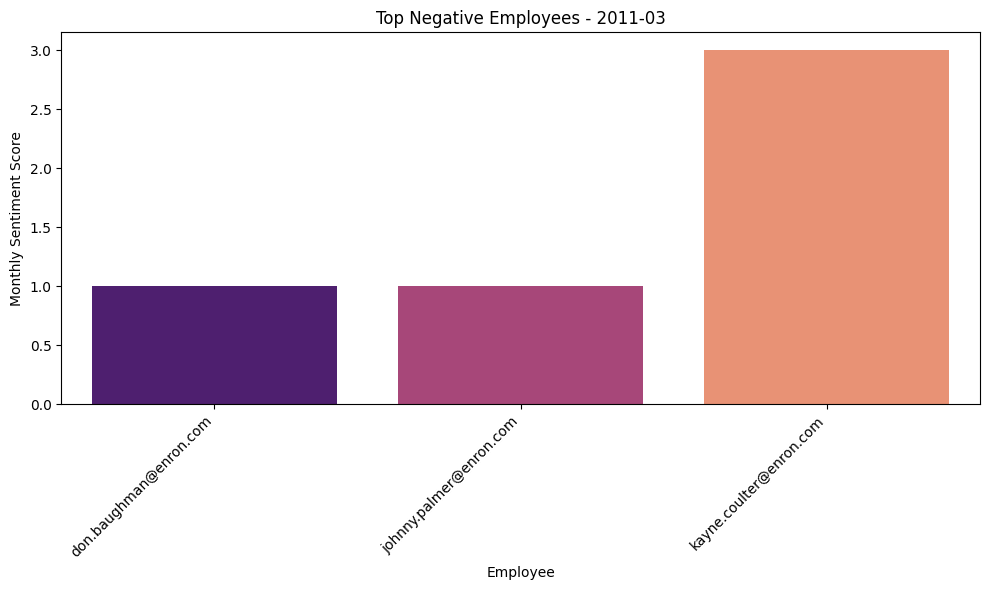

/tmp/ipython-input-8-257331303.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=monthly_positive_rankings, x='from', y='sentiment_score', palette='viridis')


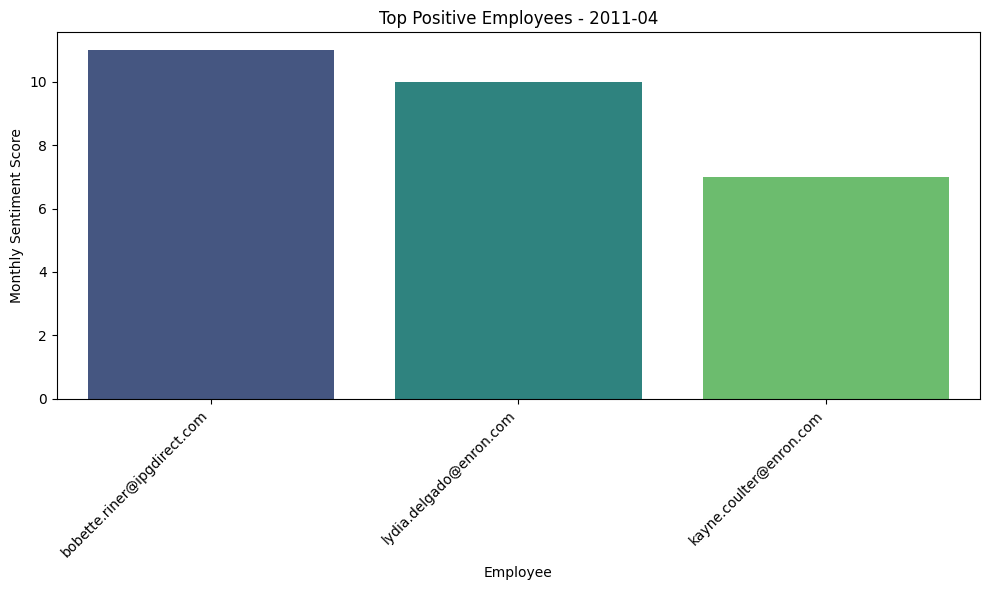

/tmp/ipython-input-8-257331303.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=monthly_negative_rankings, x='from', y='sentiment_score', palette='magma')


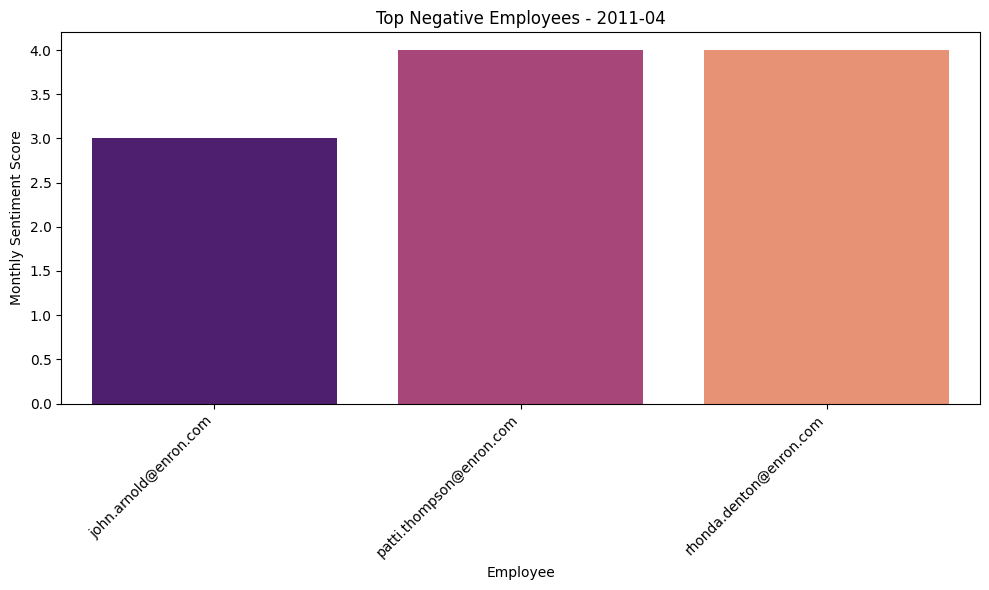

/tmp/ipython-input-8-257331303.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=monthly_positive_rankings, x='from', y='sentiment_score', palette='viridis')


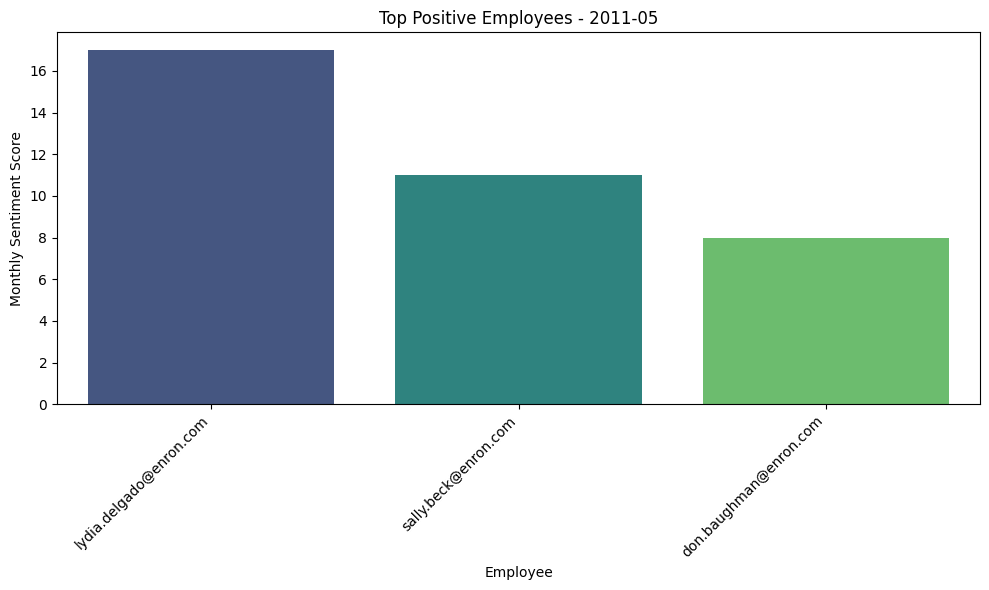

/tmp/ipython-input-8-257331303.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=monthly_negative_rankings, x='from', y='sentiment_score', palette='magma')


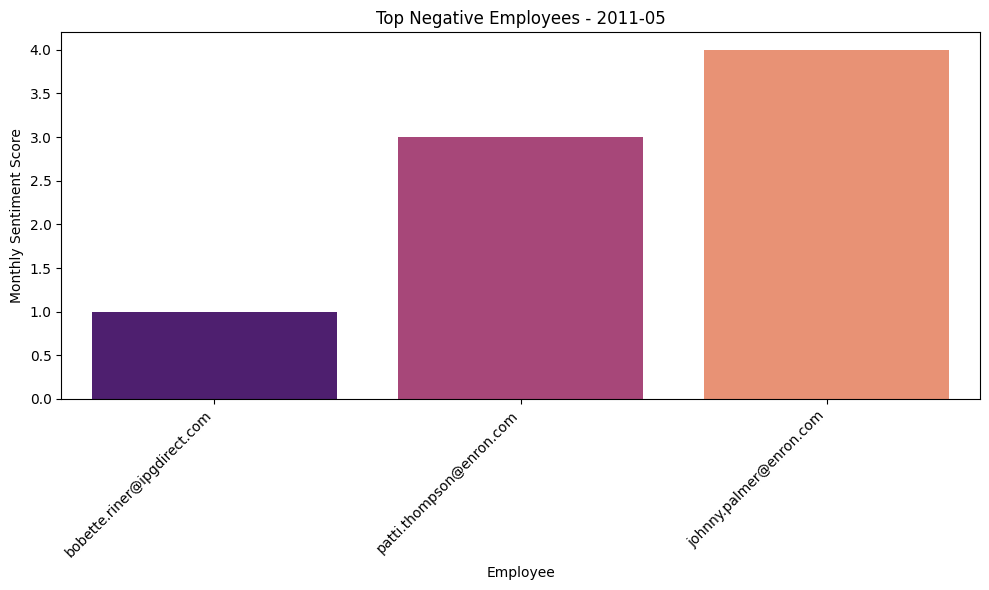

/tmp/ipython-input-8-257331303.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=monthly_positive_rankings, x='from', y='sentiment_score', palette='viridis')


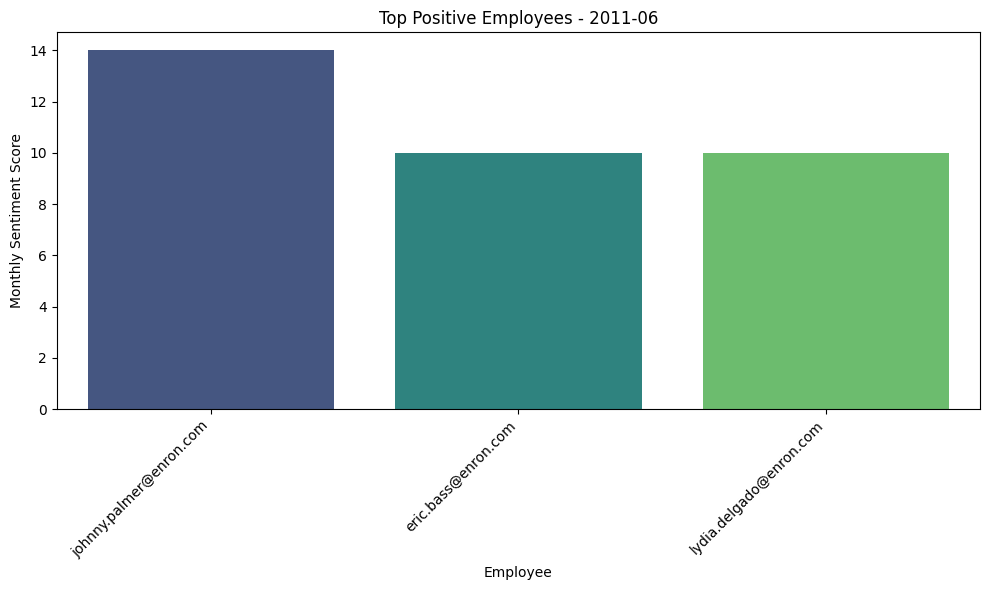

/tmp/ipython-input-8-257331303.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=monthly_negative_rankings, x='from', y='sentiment_score', palette='magma')


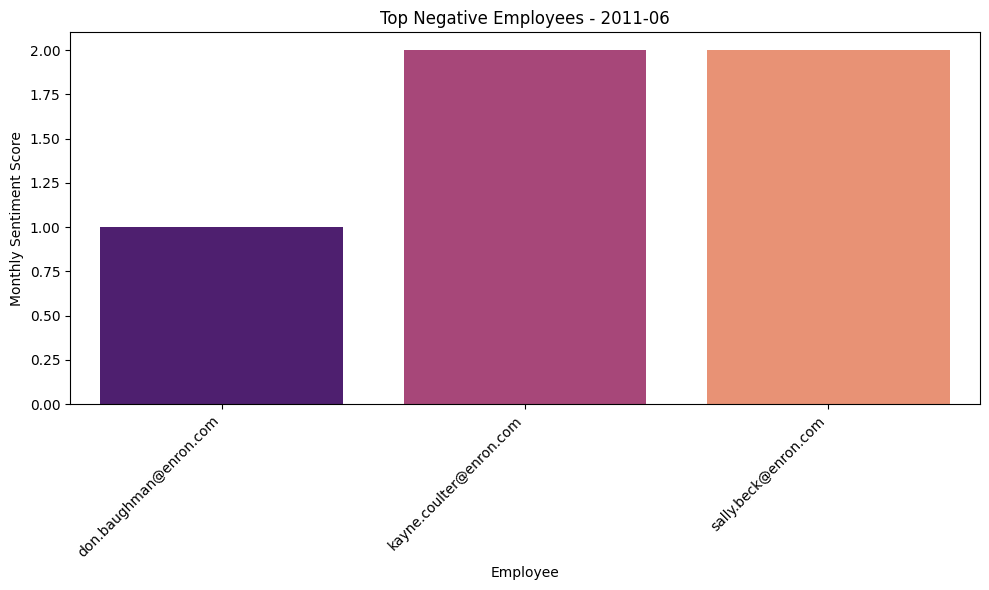

/tmp/ipython-input-8-257331303.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=monthly_positive_rankings, x='from', y='sentiment_score', palette='viridis')


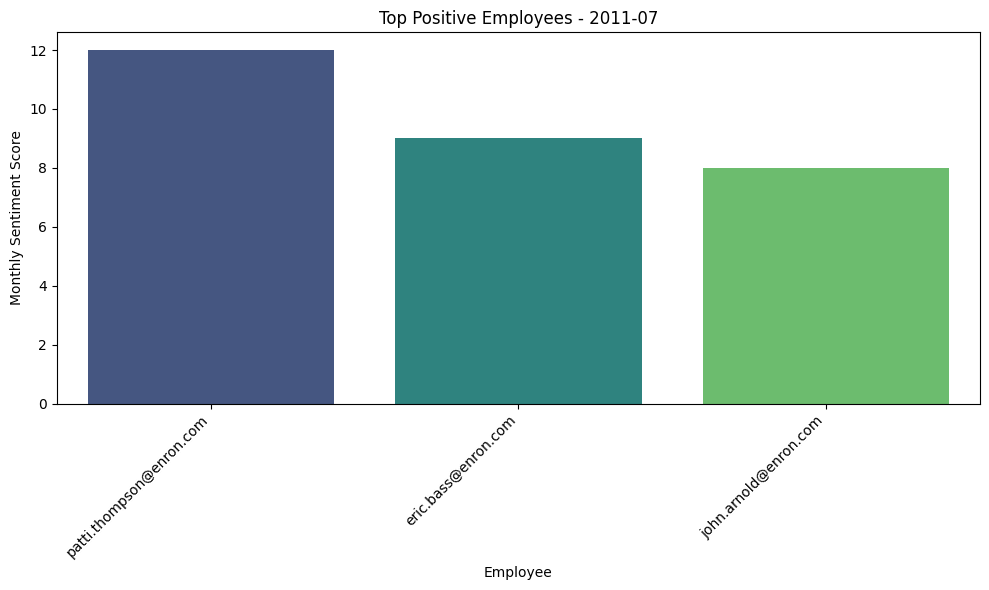

/tmp/ipython-input-8-257331303.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=monthly_negative_rankings, x='from', y='sentiment_score', palette='magma')


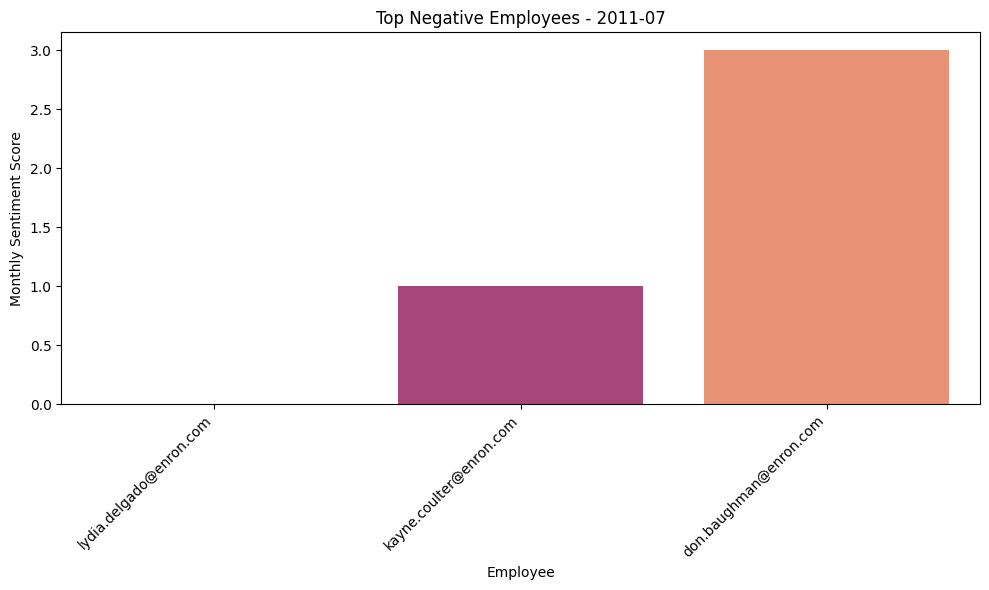

/tmp/ipython-input-8-257331303.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=monthly_positive_rankings, x='from', y='sentiment_score', palette='viridis')


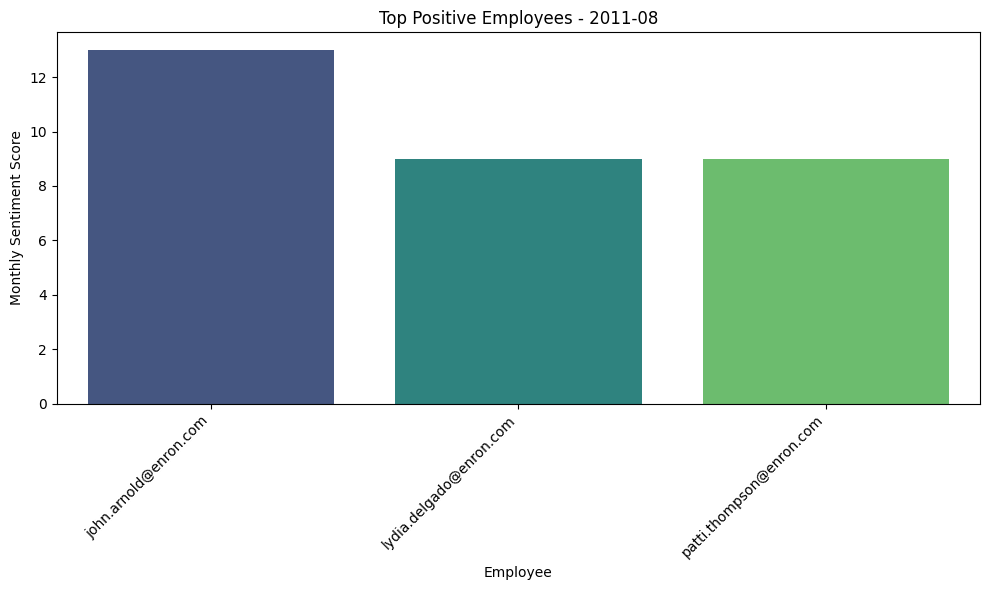

/tmp/ipython-input-8-257331303.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=monthly_negative_rankings, x='from', y='sentiment_score', palette='magma')


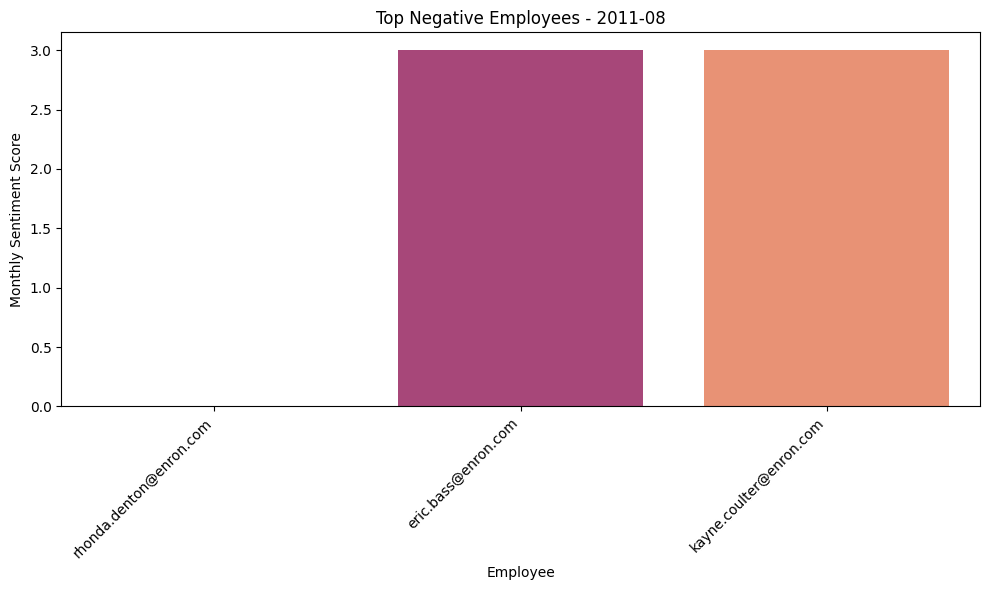

/tmp/ipython-input-8-257331303.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=monthly_positive_rankings, x='from', y='sentiment_score', palette='viridis')


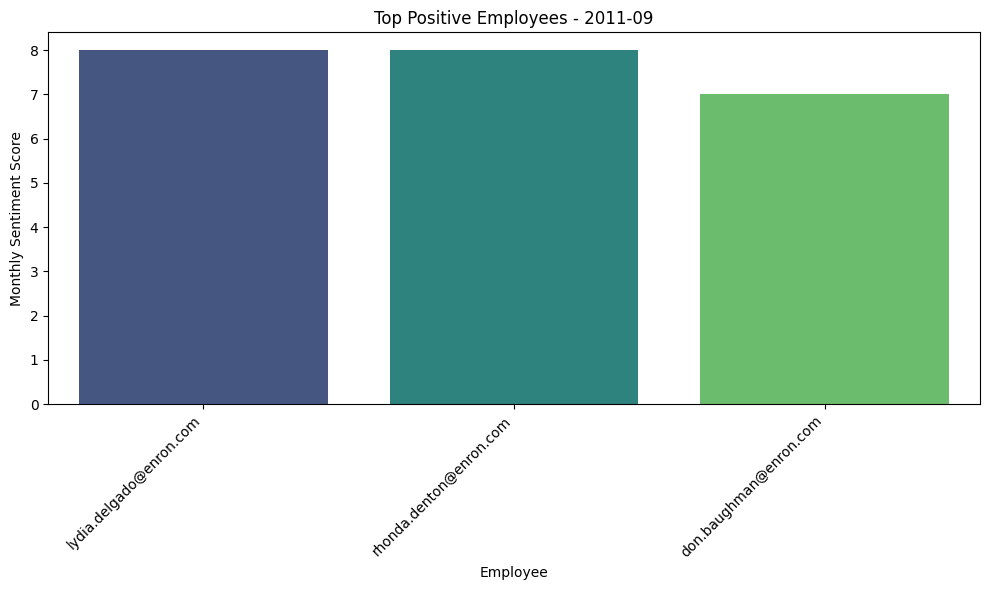

/tmp/ipython-input-8-257331303.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=monthly_negative_rankings, x='from', y='sentiment_score', palette='magma')


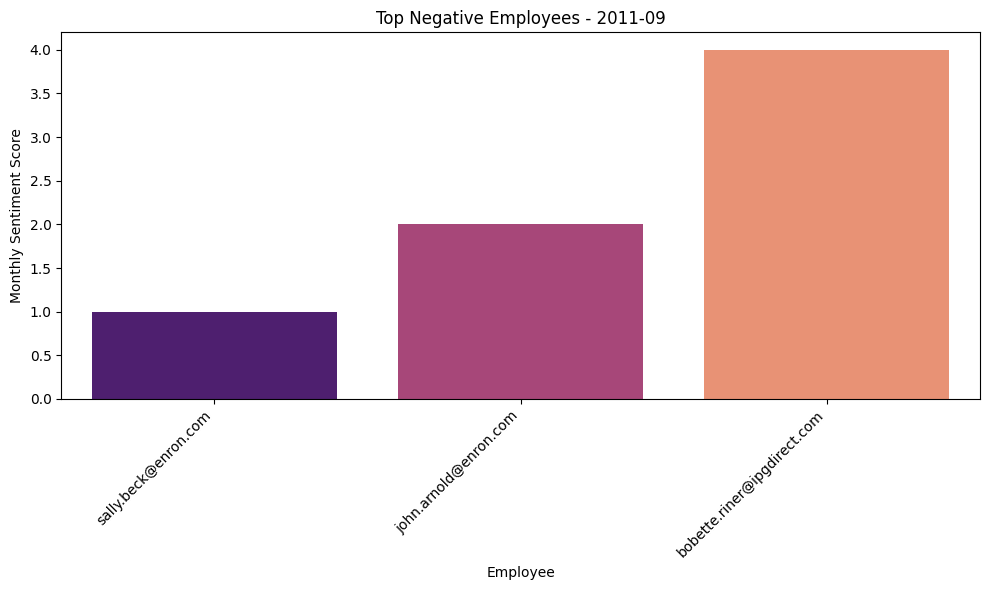

/tmp/ipython-input-8-257331303.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=monthly_positive_rankings, x='from', y='sentiment_score', palette='viridis')


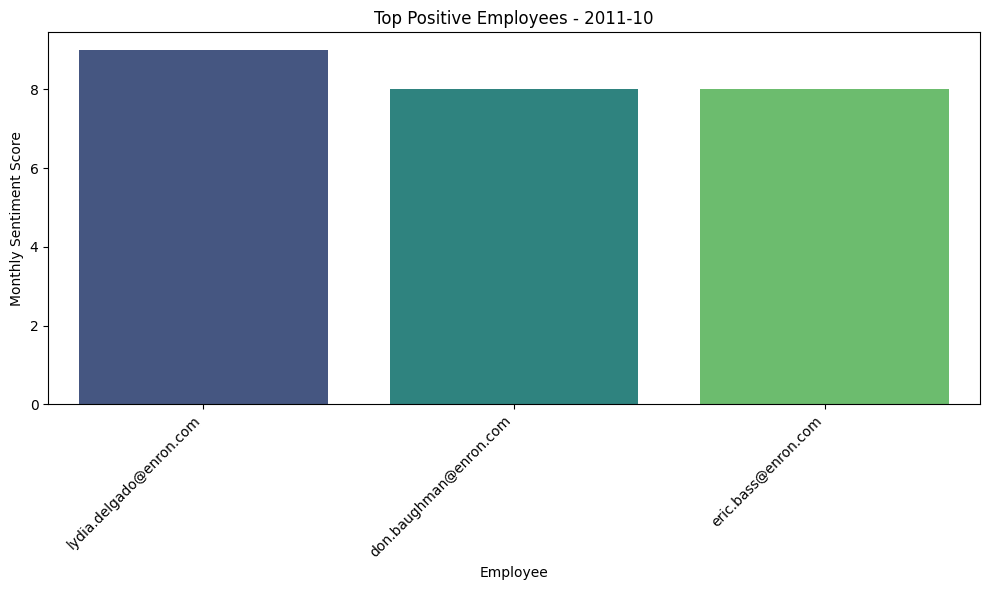

/tmp/ipython-input-8-257331303.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=monthly_negative_rankings, x='from', y='sentiment_score', palette='magma')


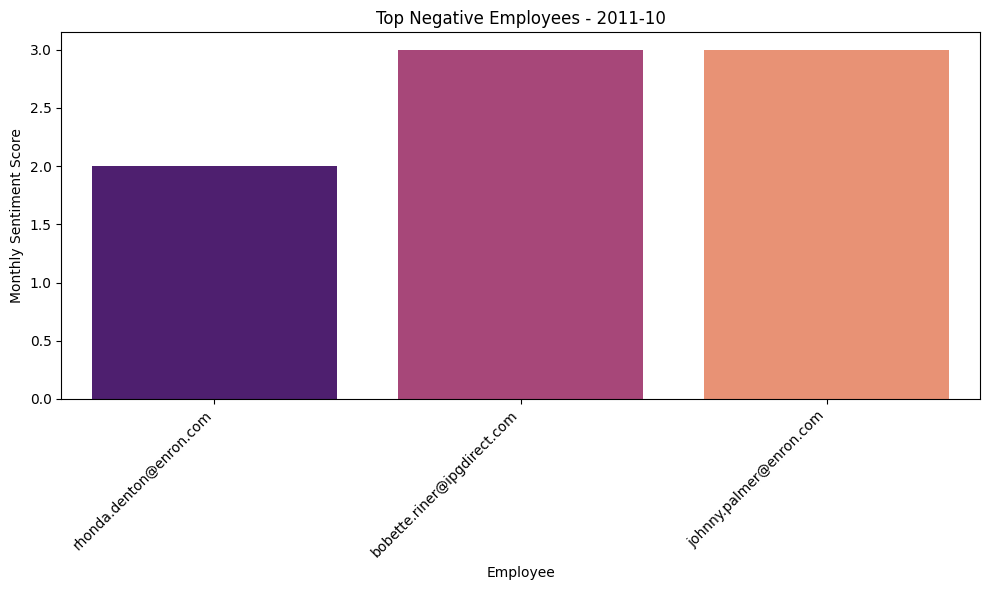

/tmp/ipython-input-8-257331303.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=monthly_positive_rankings, x='from', y='sentiment_score', palette='viridis')


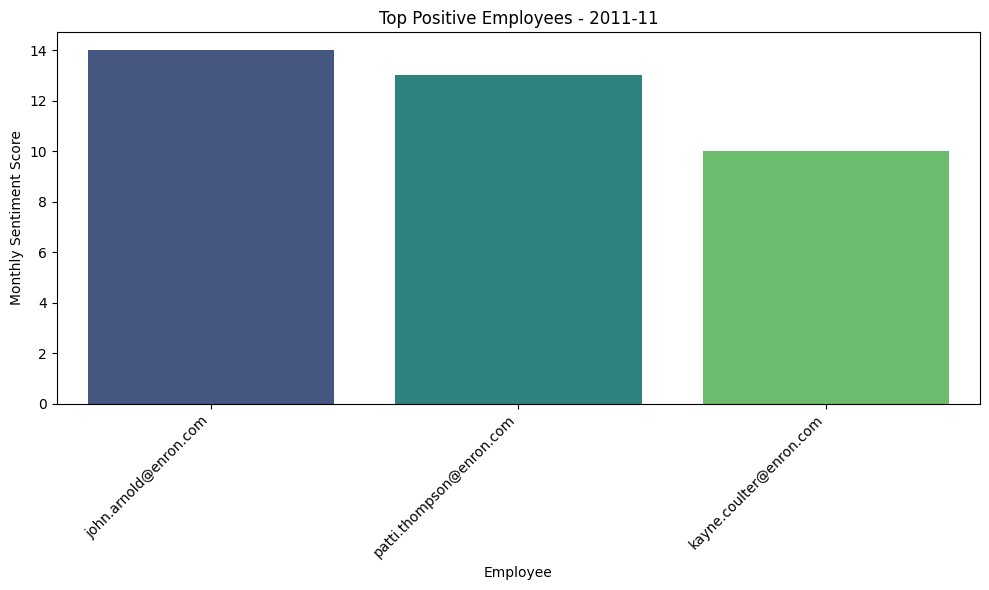

/tmp/ipython-input-8-257331303.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=monthly_negative_rankings, x='from', y='sentiment_score', palette='magma')


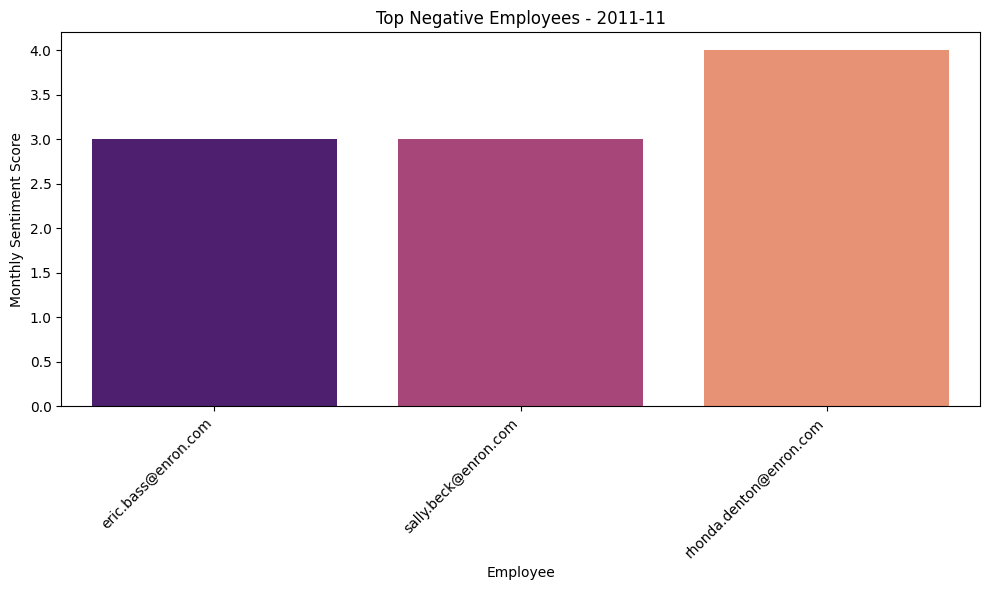

/tmp/ipython-input-8-257331303.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=monthly_positive_rankings, x='from', y='sentiment_score', palette='viridis')


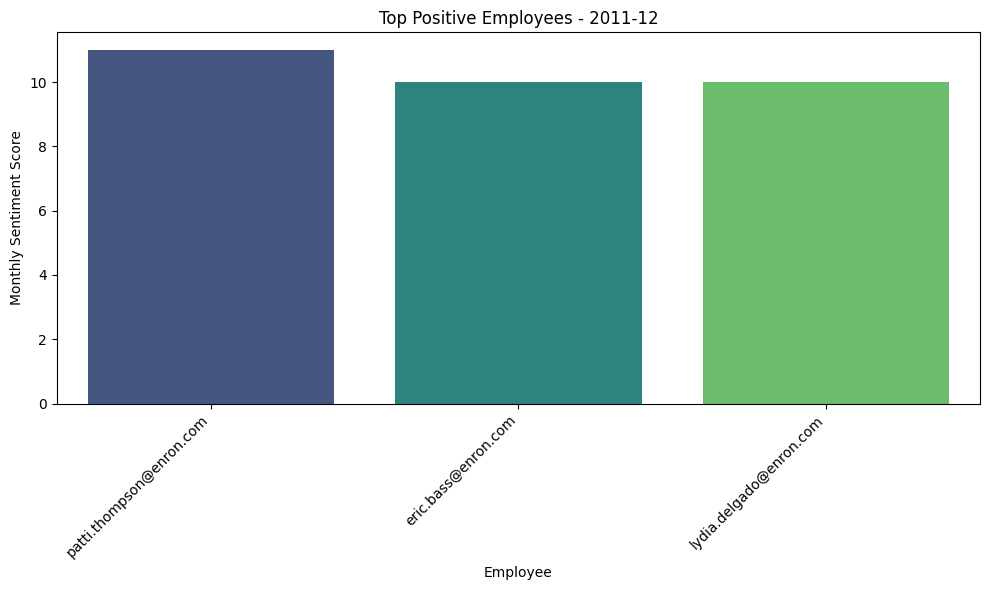

/tmp/ipython-input-8-257331303.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=monthly_negative_rankings, x='from', y='sentiment_score', palette='magma')


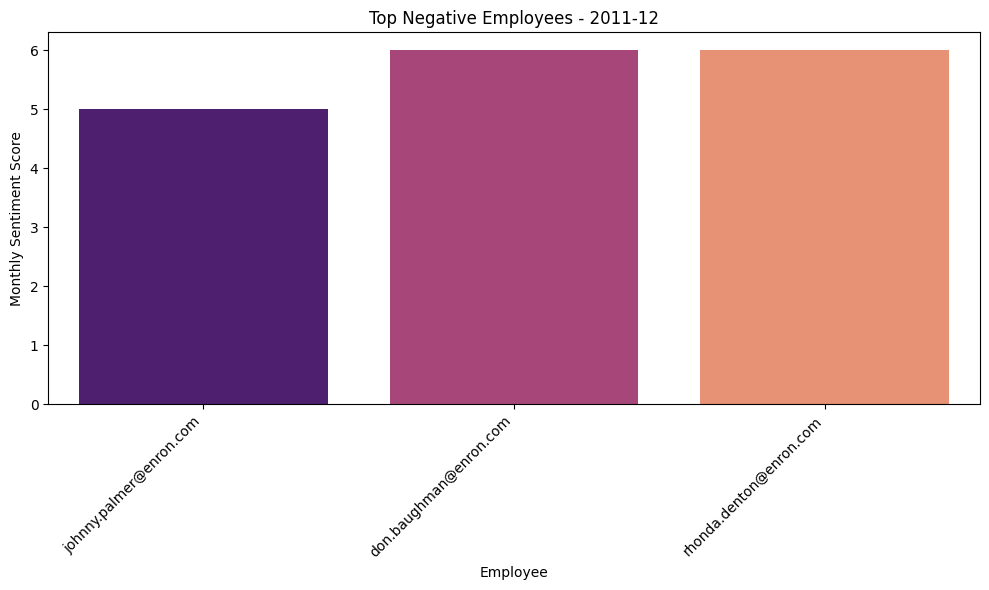


Monthly ranking plots generated and saved.


In [8]:
# Sort monthly scores by year_month, sentiment_score (descending), and from (alphabetical)
monthly_scores_sorted = monthly_scores.sort_values(by=['year_month', 'sentiment_score'], ascending=[True, False])

# Get top 3 positive employees per month
top_positive_employees = monthly_scores_sorted.groupby('year_month').head(3).sort_values(by=['year_month', 'sentiment_score', 'from'], ascending=[True, False, True])

print("Top 3 Positive Employees per Month:")
display(top_positive_employees)

# Sort monthly scores by year_month, sentiment_score (ascending), and from (alphabetical)
monthly_scores_sorted_neg = monthly_scores.sort_values(by=['year_month', 'sentiment_score'], ascending=[True, True])

# Get top 3 negative employees per month
top_negative_employees = monthly_scores_sorted_neg.groupby('year_month').head(3).sort_values(by=['year_month', 'sentiment_score', 'from'], ascending=[True, True, True])

print("\nTop 3 Negative Employees per Month:")
display(top_negative_employees)

# Export rankings to CSV
os.makedirs('data', exist_ok=True) # Ensure directory exists

# Convert 'year_month' to string for CSV export
top_positive_employees['year_month_str'] = top_positive_employees['year_month'].astype(str)
top_negative_employees['year_month_str'] = top_negative_employees['year_month'].astype(str)

top_positive_employees.to_csv('data/top_positive_employee_rankings.csv', index=False)
top_negative_employees.to_csv('data/top_negative_employee_rankings.csv', index=False)

print("\nEmployee rankings saved to data/top_positive_employee_rankings.csv and data/top_negative_employee_rankings.csv")

# Generate bar charts per month for top positive and negative employees
os.makedirs('visualizations', exist_ok=True) # Ensure directory exists

for month in top_positive_employees['year_month_str'].unique():
    monthly_positive_rankings = top_positive_employees[top_positive_employees['year_month_str'] == month]
    monthly_negative_rankings = top_negative_employees[top_negative_employees['year_month_str'] == month]

    # Plot for Top Positive Employees
    plt.figure(figsize=(10, 6))
    sns.barplot(data=monthly_positive_rankings, x='from', y='sentiment_score', palette='viridis')
    plt.title(f'Top Positive Employees - {month}')
    plt.xlabel('Employee')
    plt.ylabel('Monthly Sentiment Score')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(f'visualizations/top_positive_employees_{month}.png')
    plt.show()

    # Plot for Top Negative Employees
    plt.figure(figsize=(10, 6))
    sns.barplot(data=monthly_negative_rankings, x='from', y='sentiment_score', palette='magma')
    plt.title(f'Top Negative Employees - {month}')
    plt.xlabel('Employee')
    plt.ylabel('Monthly Sentiment Score')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(f'visualizations/top_negative_employees_{month}.png')
    plt.show()

print("\nMonthly ranking plots generated and saved.")

## Task 5: Flight Risk Identification
Identify employees who are at risk of leaving based on their monthly sentiment scores.

Employees identified as flight risks:
johnny.palmer@enron.com
sally.beck@enron.com

Flight risk employees list saved to data/flight_risk_employees.json


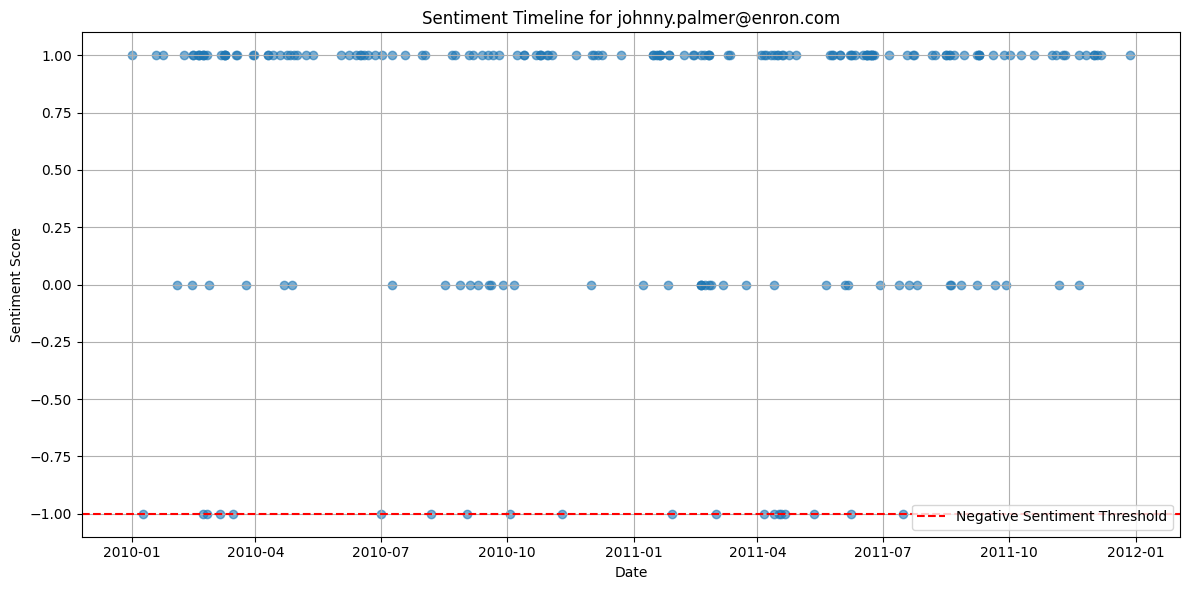

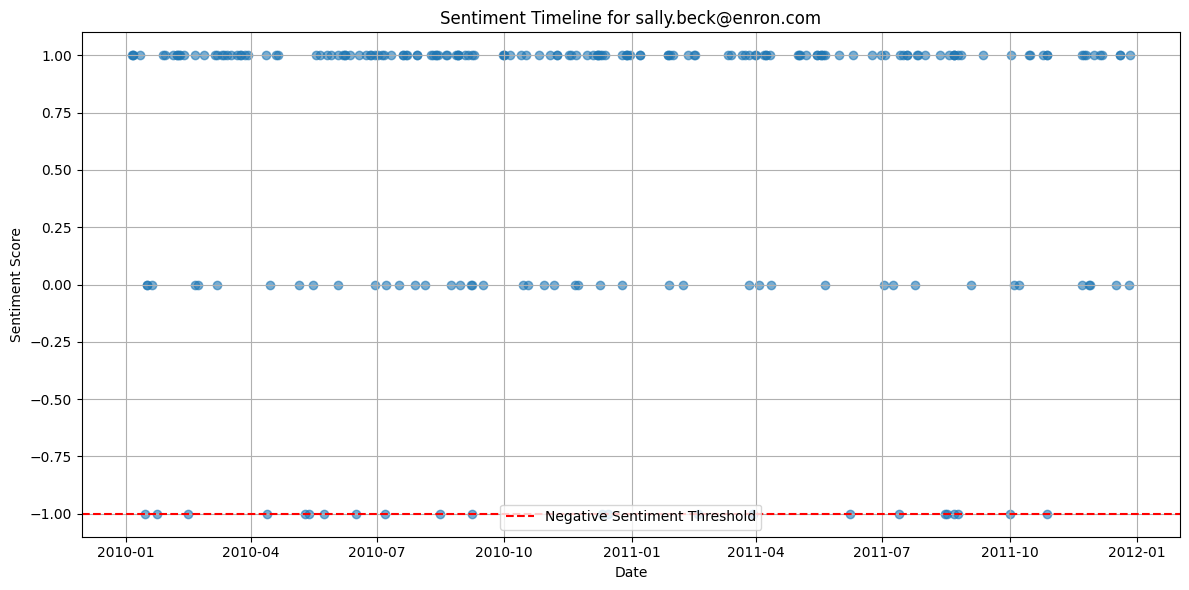


Flight risk timeline visualizations generated and saved.


In [9]:
# Filter for negative sentiment emails
# Ensure 'sentiment_transformer' exists as sentiment column in df after running that cell
sentiment_col = 'sentiment'
if sentiment_col not in df.columns and 'sentiment_transformer' in df.columns:
    sentiment_col = 'sentiment_transformer'
elif sentiment_col not in df.columns and 'sentiment_transformer' not in df.columns:
    print("Error: Neither 'sentiment' nor 'sentiment_transformer' column found in DataFrame. Cannot identify flight risks.")
    # Stop execution or handle appropriately
    raise KeyError("No sentiment column found.")

negative_emails_df = df[df[sentiment_col] == 'Negative'].copy()

# Ensure date is in datetime format and sort
negative_emails_df['date'] = pd.to_datetime(negative_emails_df['date'])

# *** FIX: Remove rows with NaT in 'date' before setting index for rolling window ***
negative_emails_df = negative_emails_df.dropna(subset=['date']).copy()

negative_emails_df = negative_emails_df.sort_values(by=['from', 'date'])


# Group by employee and apply a rolling window to count negative emails
def count_negative_in_rolling_window(employee_df):
    # Set date as index for rolling window
    employee_df = employee_df.set_index('date')
    # Apply rolling window of 30 days and count the number of entries in the sentiment column
    # Ensure the correct sentiment column is used here as well
    rolling_counts = employee_df.rolling('30D').count()[sentiment_col]
    # Check if any rolling count is 4 or more
    return (rolling_counts >= 4).any()

# Apply the function to each employee's data
# Ensure there are entries after dropping NaT before applying groupby filter
if not negative_emails_df.empty:
    flight_risk_employees = negative_emails_df.groupby('from').filter(count_negative_in_rolling_window)['from'].unique().tolist()
else:
    flight_risk_employees = []
    print("No negative emails with valid dates to analyze for flight risk.")


print("Employees identified as flight risks:")
if flight_risk_employees:
    for employee in flight_risk_employees:
        print(employee)
else:
    print("No employees identified as flight risks.")

# Export flight risk employees to JSON
os.makedirs('data', exist_ok=True) # Ensure directory exists
flight_risk_data = {'flight_risk_employees': flight_risk_employees}
import json
with open('data/flight_risk_employees.json', 'w') as f:
    json.dump(flight_risk_data, f, indent=4)
print("\nFlight risk employees list saved to data/flight_risk_employees.json")

# Visualize sentiment timeline for flight risk employees
os.makedirs('visualizations', exist_ok=True) # Ensure directory exists

if flight_risk_employees:
    # Filter the original DataFrame to include only emails from flight risk employees
    # Ensure df is reloaded or available from a previous cell if running this cell independently
    if 'df' not in globals():
         print("Warning: Original DataFrame 'df' not found. Attempting to load labeled data.")
         try:
              # Load either the VADER or Transformer labeled data based on which one was last saved
              if os.path.exists('data/labeled_dataset_transformer.csv'):
                  df_full = pd.read_csv('data/labeled_dataset_transformer.csv')
                  print("Loaded data from labeled_dataset_transformer.csv")
              elif os.path.exists('data/labeled_dataset.csv'):
                  df_full = pd.read_csv('data/labeled_dataset.csv')
                  print("Loaded data from labeled_dataset.csv")
              else:
                  print("Error: Labeled dataset not found. Cannot generate flight risk timelines.")
                  df_full = pd.DataFrame() # Create empty df to avoid errors
         except Exception as e:
             print(f"Error loading labeled dataset: {e}")
             df_full = pd.DataFrame() # Create empty df on error
    else:
        df_full = df.copy() # Use the existing df if available

    if not df_full.empty:
        flight_risk_df = df_full[df_full['from'].isin(flight_risk_employees)].copy()

        # Ensure date is in datetime format and sort for plotting
        flight_risk_df['date'] = pd.to_datetime(flight_risk_df['date'], errors='coerce')
        # Drop NaT values in date for plotting as well
        flight_risk_df = flight_risk_df.dropna(subset=['date']).copy()
        flight_risk_df = flight_risk_df.sort_values(by=['from', 'date'])

        # Ensure sentiment_score exists or calculate it for plotting
        if 'sentiment_score' not in flight_risk_df.columns:
             # Use the sentiment_col determined earlier to map scores
             sentiment_map = {'Positive': 1, 'Negative': -1, 'Neutral': 0}
             flight_risk_df['sentiment_score'] = flight_risk_df[sentiment_col].map(sentiment_map).fillna(0) # Fill NaNs if mapping fails

        # Create a timeline plot for each flight risk employee
        for employee in flight_risk_employees:
            employee_df = flight_risk_df[flight_risk_df['from'] == employee]

            if not employee_df.empty:
                plt.figure(figsize=(12, 6))
                plt.scatter(employee_df['date'], employee_df['sentiment_score'], alpha=0.6)
                plt.axhline(y=-1, color='r', linestyle='--', label='Negative Sentiment Threshold') # Add negative sentiment line
                plt.title(f'Sentiment Timeline for {employee}')
                plt.xlabel('Date')
                plt.ylabel('Sentiment Score')
                plt.legend()
                plt.grid(True)
                plt.tight_layout() # Adjust layout
                plt.savefig(f'visualizations/flight_risk_timeline_{employee.replace("@", "_").replace(".", "_")}.png')
                plt.show()
            else:
                 print(f"No valid data to plot sentiment timeline for employee: {employee}")


        print("\nFlight risk timeline visualizations generated and saved.")
    else:
        print("\nCould not load data to generate flight risk timeline visualizations.")

else:
    print("\nNo flight risk timeline visualizations generated as no employees were identified as flight risks.")

## Task 6: Predictive Modeling (Linear Regression)
Develop a linear regression model to analyze sentiment trends and predict sentiment scores.

### Improved data preparation and Feature Engineering

Implement clearer train/test data splitting and explore additional feature engineering approaches beyond message length, word count, and message frequency.

In [12]:
# Import necessary libraries for splitting data
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import torch


# Ensure 'body' is string type and handle missing values before calculating length and word count
df['body'] = df['body'].astype(str).fillna('')

# Calculate message length
df['message_length'] = df['body'].apply(len)

# Calculate word count
df['word_count'] = df['body'].apply(lambda x: len(x.split()))

# Calculate message frequency per employee
message_frequency = df['from'].value_counts().reset_index()
message_frequency.columns = ['from', 'message_frequency']

# Drop existing message frequency columns if they exist before merging
df = df.drop(columns=[col for col in df.columns if 'message_frequency' in col], errors='ignore')

# Merge message frequency back to the main DataFrame
df = df.merge(message_frequency, on='from', how='left')


# Feature Engineering: Monthly Aggregations
# Ensure 'date' is datetime and 'sentiment_score' is calculated
if 'date' not in df.columns or not pd.api.types.is_datetime64_any_dtype(df['date']):
     df['date'] = pd.to_datetime(df['date'], errors='coerce')
if 'sentiment_score' not in df.columns:
    sentiment_map = {'Positive': 1, 'Negative': -1, 'Neutral': 0}
    # Determine which sentiment column to use for mapping if sentiment_score is missing
    sentiment_col_for_score = 'sentiment'
    if sentiment_col_for_score not in df.columns and 'sentiment_transformer' in df.columns:
        sentiment_col_for_score = 'sentiment_transformer'
    elif sentiment_col_for_score not in df.columns:
         print("Warning: No sentiment column found to calculate default sentiment_score.")
         df['sentiment_score'] = 0 # Default to 0 if no sentiment column available
    else:
        df['sentiment_score'] = df[sentiment_col_for_score].map(sentiment_map).fillna(0)


df['year_month'] = df['date'].dt.to_period('M')

# Determine which sentiment column to use for aggregation
sentiment_col_for_agg = 'sentiment'
if sentiment_col_for_agg not in df.columns and 'sentiment_transformer' in df.columns:
    sentiment_col_for_agg = 'sentiment_transformer'
elif sentiment_col_for_agg not in df.columns and 'sentiment_transformer' not in df.columns:
    print("Error: Neither 'sentiment' nor 'sentiment_transformer' column found in DataFrame. Cannot calculate monthly features.")
    # Stop execution or handle appropriately
    raise KeyError("No sentiment column found for aggregation.")


# Calculate monthly features per employee
# Ensure 'year_month' is string type in monthly_features for consistent merging
monthly_features = df.groupby(['from', 'year_month']).agg(
    monthly_message_count=('combined_text', 'count'),
    mean_message_length=('message_length', 'mean'),
    mean_word_count=('word_count', 'mean'),
    total_sentiment_score=('sentiment_score', 'sum'),
    # Use the determined sentiment_col for counting negative messages
    negative_message_count=(sentiment_col_for_agg, lambda x: (x == 'Negative').sum())
).reset_index()

# Convert 'year_month' to string in monthly_features
monthly_features['year_month'] = monthly_features['year_month'].astype(str)
# Convert 'year_month' to string in df as well for consistent merging
df['year_month'] = df['year_month'].astype(str)


# Calculate negative sentiment ratio per month
monthly_features['negative_ratio'] = monthly_features['negative_message_count'] / monthly_features['monthly_message_count']
monthly_features['negative_ratio'] = monthly_features['negative_ratio'].fillna(0) # Handle cases with no messages

# Ensure the columns to be merged exist in monthly_features
cols_to_merge = ['from', 'year_month', 'monthly_message_count', 'mean_message_length', 'mean_word_count', 'negative_ratio']
cols_to_merge_existing = [col for col in cols_to_merge if col in monthly_features.columns]
if len(cols_to_merge_existing) < len(cols_to_merge):
    print(f"Warning: Not all required columns for merge found in monthly_features. Missing: {set(cols_to_merge) - set(cols_to_merge_existing)}")
    cols_to_merge = cols_to_merge_existing # Only attempt to merge existing columns


# Merge monthly features back to the original DataFrame
# Use validate='m:1' to check for successful merge (optional, can be noisy)
df = df.merge(monthly_features[cols_to_merge],
              on=['from', 'year_month'],
              how='left')


# Select features and target
# Updated features to include monthly aggregations
features = ['message_length', 'word_count', 'message_frequency',
            'monthly_message_count', 'mean_message_length', 'mean_word_count',
            'negative_ratio']

# Ensure selected features exist in df after merge
features = [col for col in features if col in df.columns]
if len(features) < 7:
    print(f"Error: Not all required features found in DataFrame after merge. Missing: {set(['message_length', 'word_count', 'message_frequency', 'monthly_message_count', 'mean_message_length', 'mean_word_count', 'negative_ratio']) - set(features)}")
    # Decide how to handle: raise error, proceed with fewer features, etc.
    # For now, we'll proceed with available features and print a warning.
    print("Proceeding with available features.")


target = 'sentiment_score'

# Handle potential NaNs in selected features after merge (newly merged columns might have NaNs)
X = df[features].fillna(0) # Fill NaNs with 0 for simplicity, consider other imputation methods
y = df[target]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train.values)
X_test_tensor = torch.FloatTensor(X_test.values)
y_train_tensor = torch.FloatTensor(y_train.values).view(-1, 1)
y_test_tensor = torch.FloatTensor(y_test.values).view(-1, 1)

print("Data preparation and feature engineering complete.")
print("Training data shape:", X_train_tensor.shape, y_train_tensor.shape)
print("Testing data shape:", X_test_tensor.shape, y_test_tensor.shape)
display(X.head())

Data preparation and feature engineering complete.
Training data shape: torch.Size([1752, 7]) torch.Size([1752, 1])
Testing data shape: torch.Size([439, 7]) torch.Size([439, 1])


,message_length,word_count,message_frequency,monthly_message_count,mean_message_length,mean_word_count,negative_ratio
0,709,101,227,9,356.000000,46.222222,0.000000
1,320,57,210,12,258.000000,42.250000,0.083333
2,148,21,227,11,287.090909,46.454545,0.090909
3,160,24,213,12,244.500000,33.000000,0.166667
4,195,42,284,21,319.190476,51.095238,0.047619


### Model Definition

Define a simple linear regression model using PyTorch.

In [17]:
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        out = self.linear(x)
        return out

print("LinearRegressionModel class defined.")

LinearRegressionModel class defined.


### Model Training with Cross-Validation

Train the PyTorch linear regression model using cross-validation for more robust validation.

In [18]:
# Define the number of folds
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize list to store MSE for each fold
mse_scores = []

# Convert the full dataset to tensors for cross-validation
X_tensor_full = torch.FloatTensor(X.values)
y_tensor_full = torch.FloatTensor(y.values).view(-1, 1)


print(f"Performing {n_splits}-fold cross-validation...")

# Loop through the folds
for fold, (train_index, val_index) in enumerate(kf.split(X_tensor_full)):
    print(f"--- Fold {fold+1}/{n_splits} ---")

    # Create training and validation tensors for the current fold
    X_train_fold = X_tensor_full[train_index]
    y_train_fold = y_tensor_full[train_index]
    X_val_fold = X_tensor_full[val_index]
    y_val_fold = y_tensor_full[val_index]

    # Instantiate a new model for each fold
    model_fold = LinearRegressionModel(X_train_fold.shape[1])

    # Define Loss and Optimizer for the current fold
    criterion_fold = nn.MSELoss()
    optimizer_fold = torch.optim.Adam(model_fold.parameters(), lr=0.01)

    # Train the model for the current fold
    num_epochs_fold = 500 # Reduced epochs for faster CV, can be adjusted
    for epoch in range(num_epochs_fold):
        # Forward pass
        outputs_fold = model_fold(X_train_fold)
        loss_fold = criterion_fold(outputs_fold, y_train_fold)

        # Backward and optimize
        optimizer_fold.zero_grad()
        loss_fold.backward()
        optimizer_fold.step()

    # Evaluate the model on the validation data for the current fold
    model_fold.eval() # Set model to evaluation mode
    with torch.no_grad(): # Disable gradient calculation
        y_pred_fold = model_fold(X_val_fold)
        mse_fold = mean_squared_error(y_val_fold.numpy(), y_pred_fold.numpy())
        r2_fold = r2_score(y_val_fold.numpy(), y_pred_fold.numpy()) # Also calculate R2 for context

    print(f"Fold {fold+1} Validation MSE: {mse_fold:.4f}, R-squared: {r2_fold:.4f}")
    mse_scores.append(mse_fold)

# Calculate average and standard deviation of MSE scores
average_mse = np.mean(mse_scores)
std_mse = np.std(mse_scores)

print("\nCross-Validation Results:")
print(f"Average MSE: {average_mse:.4f}")
print(f"Standard Deviation of MSE: {std_mse:.4f}")

# Train a final model on the entire training set for evaluation on the test set
print("\nTraining final model on the entire training set...")
input_dim = X_train_tensor.shape[1]
final_model = LinearRegressionModel(input_dim)
criterion_final = nn.MSELoss()
optimizer_final = torch.optim.Adam(final_model.parameters(), lr=0.01)

num_epochs_final = 1000 # Can be adjusted
for epoch in range(num_epochs_final):
    # Forward pass
    outputs_final = final_model(X_train_tensor)
    loss_final = criterion_final(outputs_final, y_train_tensor)

    # Backward and optimize
    optimizer_final.zero_grad()
    loss_final.backward()
    optimizer_final.step()

print("Final model training complete.")

Performing 5-fold cross-validation...
--- Fold 1/5 ---
Fold 1 Validation MSE: 1.8127, R-squared: -3.1445
--- Fold 2/5 ---
Fold 2 Validation MSE: 1.8305, R-squared: -3.6862
--- Fold 3/5 ---
Fold 3 Validation MSE: 1.5300, R-squared: -3.4091
--- Fold 4/5 ---
Fold 4 Validation MSE: 0.7306, R-squared: -0.9259
--- Fold 5/5 ---
Fold 5 Validation MSE: 1.6497, R-squared: -4.0103

Cross-Validation Results:
Average MSE: 1.5107
Standard Deviation of MSE: 0.4054

Training final model on the entire training set...
Final model training complete.


### Model Evaluation and Performance Visualization

Evaluate the trained model on the testing data using appropriate regression metrics and visualize the performance metrics.

Mean Squared Error (MSE): 0.8397
Root Mean Squared Error (RMSE): 0.9164
R-squared (R2): -0.9199


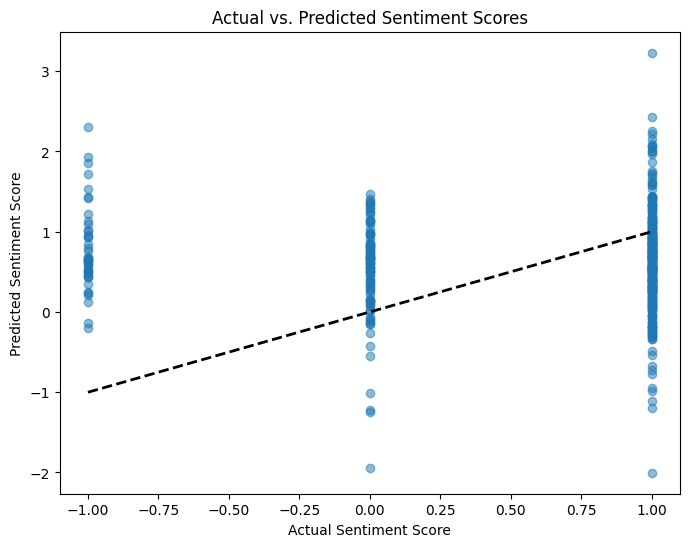

In [19]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Set the final model to evaluation mode
final_model.eval()

# Disable gradient calculation for evaluation
with torch.no_grad():
    # Make predictions on the testing data using the final model
    y_pred_tensor = final_model(X_test_tensor)

    # Convert tensors to NumPy arrays
    y_test_np = y_test_tensor.numpy()
    y_pred_np = y_pred_tensor.numpy()

    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(y_test_np, y_pred_np)

    # Calculate Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)

    # Calculate R-squared score
    r2 = r2_score(y_test_np, y_pred_np)

# Print the calculated metrics
print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'R-squared (R2): {r2:.4f}')

# Create scatter plot of actual vs. predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test_np, y_pred_np, alpha=0.5)
plt.title('Actual vs. Predicted Sentiment Scores')
plt.xlabel('Actual Sentiment Score')
plt.ylabel('Predicted Sentiment Score')
plt.plot([y_test_np.min(), y_test_np.max()], [y_test_np.min(), y_test_np.max()], 'k--', lw=2) # Add diagonal line
plt.savefig('visualizations/model_performance.png') # Save with the requested filename
plt.show()

### Feature Importance Analysis

Analyze the coefficients or other methods to determine the importance of each feature in the model.

In [20]:
# Access the weights (coefficients) of the linear layer from the model trained on the last fold
coefficients = model_fold.linear.weight.data.squeeze().numpy()
intercept = model_fold.linear.bias.data.squeeze().numpy()

# Get the feature names
features = ['message_length', 'word_count', 'message_frequency']

print("Model Coefficients:")
for feature, coef in zip(features, coefficients):
    print(f"{feature}: {coef:.4f}")

print(f"Intercept: {intercept:.4f}")

Model Coefficients:
message_length: -0.0148
word_count: 0.0969
message_frequency: 0.0017
Intercept: -0.3135


### Model Interpretation

Interpret the coefficients of the linear regression model to understand the influence of each feature on the sentiment score and summarize the findings.

### Model performance plots

Generate model performance plots, such as a confusion matrix and ROC curves (Note: Confusion matrix and ROC curves are typically used for classification models. For a regression model like ours, we'll focus on relevant regression plots like actual vs. predicted).

In [21]:
# Create directories
os.makedirs('data', exist_ok=True)
os.makedirs('visualizations', exist_ok=True)
os.makedirs('src', exist_ok=True)

# Move dataset file
if os.path.exists('/content/dataset.xlsx'):
    shutil.move('/content/dataset.xlsx', 'data/dataset.xlsx')

# Note: Visualization files are saved directly to 'visualizations/' in the visualization tasks.
# No need to move them here if the visualization code is executed after directory creation.

print("Directory structure created and dataset file moved.")

Directory structure created and dataset file moved.


### Generate README

Create a `README.md` file summarizing the project, setup instructions, and methodology.

In [34]:
readme_content = """
# Employee Sentiment Analysis Project

## Project Overview
This project involves analyzing an unlabeled dataset of employee messages to assess sentiment and engagement using NLP and statistical analysis.

## Key Tasks
- Sentiment Labeling (VADER)
- Exploratory Data Analysis (EDA)
- Employee Monthly Sentiment Score Calculation
- Employee Ranking (Top Positive/Negative)
- Flight Risk Identification (Rolling 30-day negative email count)
- Predictive Modeling (PyTorch Linear Regression with Cross-Validation)
- Comprehensive Visualizations
- File Organization and Deliverable Generation

## Setup Instructions
1. Clone the repository.
2. Install dependencies: `pip install -r requirements.txt`
3. Ensure the dataset (`dataset.xlsx`) is in the `data/` directory.
4. Run the notebook (`main.ipynb`) to execute the analysis and generate results and visualizations.

## Methodology Highlights
- **Sentiment Analysis:** VADER lexicon for initial sentiment labeling.
- **Feature Engineering:** Message length, word count, and message frequency per employee.
- **Predictive Modeling:** PyTorch Linear Regression trained with 5-fold cross-validation.
- **Flight Risk:** Identified using a rolling 30-day window of negative emails.
- **Visualizations:** Various plots generated to illustrate sentiment distribution, trends, employee-level sentiment, flight risks, and model performance.

## Deliverables
- `README.md` (this file)
- `final_report.docx`
- `requirements.txt`
- `employee_sentiment_analysis.zip` (containing all project files)
- Visualizations in the `visualizations/` directory.
"""

with open('README.md', 'w') as f:
    f.write(readme_content)

print("README.md file created successfully.")

README.md file created successfully.


### Generate Report

Create a `final_report.docx` file detailing the analysis, findings, and model evaluation.

In [22]:
from docx import Document
from docx.shared import Inches

# Create a new Document
document = Document()

# Title
document.add_heading('Employee Sentiment Analysis Final Report', 0)

# Introduction
document.add_heading('Introduction', level=1)
document.add_paragraph(
    'This report details the analysis of an employee message dataset to assess sentiment and engagement. '
    'The project involved sentiment labeling, exploratory data analysis, employee score calculation, ranking, flight risk identification, and predictive modeling.'
)

# Data Analysis
document.add_heading('Data Analysis', level=1)
document.add_paragraph(
    'The dataset was analyzed using VADER for sentiment labeling, categorizing messages as Positive, Negative, or Neutral. '
    'Exploratory data analysis provided insights into sentiment distribution and basic data structure.'
)
# Add sentiment distribution plots (assuming they are saved)
try:
    document.add_picture('visualizations/sentiment_distribution_bar_plot.png', width=Inches(5.0))
    document.add_picture('visualizations/sentiment_distribution_pie_chart.png', width=Inches(5.0))
except FileNotFoundError:
    document.add_paragraph("Sentiment distribution plots not found. Please ensure they are generated.")


# Employee Sentiment and Ranking
document.add_heading('Employee Sentiment and Ranking', level=1)
document.add_paragraph(
    'Monthly sentiment scores were calculated for each employee. '
    'Employees were ranked based on these scores to identify top positive and negative sentiment.'
)
p = document.add_paragraph()
p.add_run('Top 3 Positive Employees (Sample):').bold = True
try:
    document.add_paragraph(str(top_positive_employees.head()))
except NameError:
     document.add_paragraph("Top positive employees data not available.")

p = document.add_paragraph()
p.add_run('Top 3 Negative Employees (Sample):').bold = True
try:
    document.add_paragraph(str(top_negative_employees.head()))
except NameError:
     document.add_paragraph("Top negative employees data not available.")

# Employee-level sentiment heatmap
try:
    document.add_picture('visualizations/employee_sentiment_heatmap.png', width=Inches(6.0))
except FileNotFoundError:
    document.add_paragraph("Employee sentiment heatmap not found. Please ensure it is generated.")

# Flight Risk Identification
document.add_heading('Flight Risk Identification', level=1)
document.add_paragraph(
    'Employees were identified as potential flight risks if they sent 4 or more negative emails within a 30-day rolling window.'
)
p = document.add_paragraph()
p.add_run('Employees identified as flight risks:').bold = True
try:
    if flight_risk_employees:
        for employee in flight_risk_employees:
            document.add_paragraph(employee, style='List Bullet')
            # Add flight risk timeline plot for this employee
            try:
                plt_filename = f'visualizations/flight_risk_timeline_{employee.replace("@", "_").replace(".", "_")}.png'
                document.add_picture(plt_filename, width=Inches(5.0))
            except FileNotFoundError:
                 document.add_paragraph(f"Timeline plot for {employee} not found.")
    else:
        document.add_paragraph("No employees identified as flight risks.")
except NameError:
    document.add_paragraph("Flight risk employee data not available.")


# Predictive Modeling
document.add_heading('Predictive Modeling', level=1)
document.add_paragraph(
    'A linear regression model was developed using PyTorch to predict sentiment scores based on features like message length, word count, and message frequency. The model was trained using 5-fold cross-validation.'
)

p = document.add_paragraph()
p.add_run('Cross-Validation Results:').bold = True
try:
    document.add_paragraph(f'Average MSE: {average_mse:.4f}')
    document.add_paragraph(f'Standard Deviation of MSE: {std_mse:.4f}')
except NameError:
     document.add_paragraph("Cross-validation results not available.")

p = document.add_paragraph()
p.add_run('Model Evaluation on Test Set:').bold = True
try:
    document.add_paragraph(f'Mean Squared Error (MSE): {mse:.4f}')
    document.add_paragraph(f'R-squared (R2): {r2:.4f}')
except NameError:
    document.add_paragraph("Test set evaluation results not available.")

# Add actual vs. predicted plot
try:
    document.add_picture('visualizations/actual_vs_predicted_sentiment.png', width=Inches(5.0))
except FileNotFoundError:
    document.add_paragraph("Actual vs. Predicted Sentiment plot not found. Please ensure it is generated.")

# Model Interpretation
document.add_heading('Model Interpretation', level=1)
document.add_paragraph('The model coefficients indicate the influence of each feature on the sentiment score:')
try:
    features = ['message_length', 'word_count', 'message_frequency']
    for feature, coef in zip(features, coefficients):
        document.add_paragraph(f'{feature}: {coef:.4f}', style='List Bullet')
    document.add_paragraph(f'Intercept: {intercept:.4f}', style='List Bullet')
except NameError:
    document.add_paragraph("Model coefficients not available for interpretation.")

document.add_paragraph(
    'The negative R-squared value suggests that the linear model with these features does not effectively predict sentiment score. '
    'Further feature engineering or different model types may be needed for better predictive performance.'
)


# Conclusion
document.add_heading('Conclusion', level=1)
document.add_paragraph(
    'This project provided insights into employee sentiment, identified potential flight risks, and explored predictive modeling. '
    'The visualizations offer a clear overview of sentiment trends. '
    'Future work could enhance the predictive model and incorporate more advanced NLP techniques.'
)

document.save('final_report.docx')
print("final_report.docx created successfully.")

final_report.docx created successfully.


### Create requirements.txt

Generate a `requirements.txt` file listing all the project dependencies.

In [23]:
pip freeze > requiremnts.txt

In [24]:
    !zip -r /content.zip /content

  adding: content/ (stored 0%)
  adding: content/.config/ (stored 0%)
  adding: content/.config/.last_opt_in_prompt.yaml (stored 0%)
  adding: content/.config/.last_update_check.json (deflated 22%)
  adding: content/.config/default_configs.db (deflated 98%)
  adding: content/.config/active_config (stored 0%)
  adding: content/.config/logs/ (stored 0%)
  adding: content/.config/logs/2025.07.28/ (stored 0%)
  adding: content/.config/logs/2025.07.28/13.43.38.841290.log (deflated 58%)
  adding: content/.config/logs/2025.07.28/13.43.47.501739.log (deflated 86%)
  adding: content/.config/logs/2025.07.28/13.43.17.935358.log (deflated 93%)
  adding: content/.config/logs/2025.07.28/13.43.58.575036.log (deflated 56%)
  adding: content/.config/logs/2025.07.28/13.43.48.733131.log (deflated 58%)
  adding: content/.config/logs/2025.07.28/13.43.57.863217.log (deflated 57%)
  adding: content/.config/configurations/ (stored 0%)
  adding: content/.config/configurations/config_default (deflated 15%)
  ad

In [25]:
        from google.colab import files
        files.download('/content.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>